In [1]:
# %% [markdown]
# # Jupyter Notebook Loading Header
#
# This is a custom loading header for Jupyter Notebooks in Visual Studio Code.
# It includes common imports and settings to get you started quickly.

# %% [markdown]
## Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery
import os
path = r'C:\Users\DwaipayanChakroborti\AppData\Roaming\gcloud\legacy_credentials\dchakroborti@tonikbank.com\adc.json'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = path
client = bigquery.Client(project='prj-prod-dataplatform')

# %% [markdown]
## Configure Settings
# Set options or configurations as needed
# Example: pd.set_option('display.max_columns', None)

In [2]:
sq = """select customerId, count(distinct digitalLoanAccountId) cntloans 
, count(distinct CBContractCode) loanincb
, sum(case when cast(ContractStartDate as date) < current_date() and ContractPhaseDesc = 'Closed' then 1 else 0 end) closedcontract
, sum(case when cast(ContractStartDate as date) < current_date() and  ContractPhaseDesc = 'Closed in advance' then 1 else 0 end) closedinadvancecontract
, sum(case when cast(ContractStartDate as date) < current_date() and ContractPhaseDesc = 'Active' then 1 else 0 end) Activecontract
from prj-prod-dataplatform.risk_credit_cic_data.granted_contracts
group by 1
;
"""

dfgrantedcontractcnt = client.query(sq).to_dataframe(progress_bar_type = 'tqdm')
dfgrantedcontractcnt.head()

Job ID 187e8fc6-3021-4ac2-b024-d777c14213aa successfully executed: 100%|██████████|
Downloading: 100%|██████████|


,customerId,cntloans,loanincb,closedcontract,closedinadvancecontract,Activecontract
0,1879052,1,27,26,0,1
1,1879169,1,34,18,0,16
2,2075712,2,21,22,0,15
3,2196936,2,47,16,32,28
4,2198034,1,26,19,0,7


# Duplicate find

In [3]:
# Check for duplicate digitalLoanAccountId
has_duplicates = dfgrantedcontractcnt['customerId'].duplicated()

# Get the actual duplicate loan ids
duplicate_ids = dfgrantedcontractcnt[has_duplicates]['customerId']

# Print the duplicate loan ids
if duplicate_ids.empty:
    print("There are no duplicate digitalLoanAccountId in the dataframe.")
else:
    print("The following digitalLoanAccountId are duplicates:")
    print(duplicate_ids.tolist())

There are no duplicate digitalLoanAccountId in the dataframe.


# Getting the base query ready with CustomerId the common column

`CRITERIA`<BR>
Only for quick loans and for customers with disbursed loan after 2023-01-01 and obsTPD30 = 1

In [4]:
sq = """with customerbase as 
(select customerId, loanAccountNumber, disbursementDateTime, 
row_number() over (partition by customerId order by disbursementDateTime desc) rnk
from `risk_credit_mis.loan_master_table` where flagDisbursement = 1 and date_trunc(disbursementDateTime, day) >= '2023-01-01'
and upper(new_loan_type) = 'QUICK'),
fstpd as
(select lmt.customerId, lmt.loanAccountNumber, lmt.new_loan_type,
sum(case when obsTPD30 = 1
     then case when defFPD30 = 1 then 1
     when defSPD30 = 1 then 1
     when defTPD30 = 1 then 1
     else 0 end else 0 end) FPSTPD30 ,
sum(obsTPD30) obsTPD30,
max(cb.rnk) rnk
 from `risk_credit_mis.loan_master_table` lmt
 inner join customerbase cb on cb.customerId = lmt.customerId and lmt.loanAccountNumber = cb.loanAccountNumber
 WHERE 
  date_trunc(lmt.disbursementDateTime, day) >= '2023-01-01' and upper(lmt.new_loan_type) = 'QUICK'
 group by 1,2,3
),
modelpopulationbase as
(select customerId,new_loan_type,count(distinct loanAccountNumber) cnt_loans
, sum(obsTPD30) obs
, sum(FPSTPD30)FSTPD30 
from fstpd where obsTPD30 = 1 group by 1,2
) 
select customerId,new_loan_type,
max(case when obs > 0 then 1 else 0 end) obs ,
max(case when FSTPD30 > 0 then 1 else 0 end) fstpd30
from modelpopulationbase 
group by 1, 2
;
"""

In [5]:
base = client.query(sq).to_dataframe(progress_bar_type='tqdm')
print(f"The rows and columns downloaded after running the above query are:\n{base.shape}")

Job ID 8be084e6-ff9c-4538-b645-c304abb2a150 successfully executed: 100%|██████████|
Downloading: 100%|██████████|
The rows and columns downloaded after running the above query are:
(17613, 4)


In [6]:
base.head()

,customerId,new_loan_type,obs,fstpd30
0,2169925,Quick,1,0
1,2025886,Quick,1,0
2,2224518,Quick,1,0
3,2029675,Quick,1,0
4,2041621,Quick,1,0


In [7]:
dfgrantedcontractcnt['customerId'] = dfgrantedcontractcnt['customerId'].astype(np.int64)

In [8]:
df = base.merge(dfgrantedcontractcnt, left_on='customerId', right_on = 'customerId', how='left')
df.columns

Index(['customerId', 'new_loan_type', 'obs', 'fstpd30', 'cntloans', 'loanincb',
       'closedcontract', 'closedinadvancecontract', 'Activecontract'],
      dtype='object')

In [9]:
print(f"The shape of dataframe dfgrantedcontractcnt are:/t {dfgrantedcontractcnt.shape}")
print(f"The shape of dataframe base are:/t {base.shape}")
print(f"The shape of dataframe df are:/t {df.shape}")

The shape of dataframe dfgrantedcontractcnt are:/t (84289, 6)
The shape of dataframe base are:/t (17613, 4)
The shape of dataframe df are:/t (17613, 9)


In [10]:
df.head()

,customerId,new_loan_type,obs,fstpd30,cntloans,loanincb,closedcontract,closedinadvancecontract,Activecontract
0,2169925,Quick,1,0,1,3,2,0,1
1,2025886,Quick,1,0,<NA>,<NA>,<NA>,<NA>,<NA>
2,2224518,Quick,1,0,<NA>,<NA>,<NA>,<NA>,<NA>
3,2029675,Quick,1,0,<NA>,<NA>,<NA>,<NA>,<NA>
4,2041621,Quick,1,0,1,10,2,1,7


In [11]:
df.fillna(0, inplace=True)

In [12]:
# use pandas cut() function to bin the loanincb column into 5 equal-width bins
df['loanincb_bin'] = pd.cut(df['loanincb'], bins=5)
df['closedcontract_bin'] = pd.cut(df['closedcontract'], bins=5)
df['closedinadvancecontract_bin'] = pd.cut(df['closedinadvancecontract'],bins=5)
df['Activecontract_bin'] = pd.cut(df ['Activecontract'], bins=5)
df['cntloans_bin'] = pd.cut(df['cntloans'], bins=5)

In [13]:
df.drop(columns=['cntloans', 'loanincb', 'closedcontract',
       'closedinadvancecontract', 'Activecontract'], inplace=True)

In [14]:
df.columns

Index(['customerId', 'new_loan_type', 'obs', 'fstpd30', 'loanincb_bin',
       'closedcontract_bin', 'closedinadvancecontract_bin',
       'Activecontract_bin', 'cntloans_bin'],
      dtype='object')

In [15]:
df.head()

,customerId,new_loan_type,obs,fstpd30,loanincb_bin,closedcontract_bin,closedinadvancecontract_bin,Activecontract_bin,cntloans_bin
0,2169925,Quick,1,0,"(-0.09, 18.0]","(-0.2, 40.0]","(-0.167, 33.4]","(-0.146, 29.2]","(-0.007, 1.4]"
1,2025886,Quick,1,0,"(-0.09, 18.0]","(-0.2, 40.0]","(-0.167, 33.4]","(-0.146, 29.2]","(-0.007, 1.4]"
2,2224518,Quick,1,0,"(-0.09, 18.0]","(-0.2, 40.0]","(-0.167, 33.4]","(-0.146, 29.2]","(-0.007, 1.4]"
3,2029675,Quick,1,0,"(-0.09, 18.0]","(-0.2, 40.0]","(-0.167, 33.4]","(-0.146, 29.2]","(-0.007, 1.4]"
4,2041621,Quick,1,0,"(-0.09, 18.0]","(-0.2, 40.0]","(-0.167, 33.4]","(-0.146, 29.2]","(-0.007, 1.4]"


# Weight of Evidence Function and Information Value

In [16]:
def woe_iv(df, feature, target):
    """
    Calculate the Weight of Evidence (WOE) and Information Value (IV) for a given feature and target variable in a pandas DataFrame.
   
    Parameters:
    df (pandas.DataFrame): The DataFrame containing the feature and target variables.
    feature (str): The name of the feature variable.
    target (str): The name of the target variable.
   
    Returns:
    pandas.DataFrame: A DataFrame containing the WOE and IV for each unique value of the feature variable.
    """
   
    # Calculate the total number of events and non-events in the target variable
    total_events = df[target].sum()
    total_non_events = df[target].count() - total_events
   
    # Group the DataFrame by unique values of the feature variable
    grouped = df.groupby(feature)
   
    # Calculate the number of events and non-events in each group
    events = grouped[target].sum()
    non_events = grouped[target].count() - events
   
    # Calculate the percentage of events and non-events in each group
    event_pct = events / total_events
    non_event_pct = non_events / total_non_events
   
    # Calculate the WOE for each group
    woe = np.log(non_event_pct / event_pct)
   
    # Calculate the IV for each group
    iv = (non_event_pct - event_pct) * woe
   
    # Combine the results into a DataFrame
    result = pd.DataFrame({
        'event': events,
        'non_event': non_events,
        'event_pct': event_pct,
        'non_event_pct': non_event_pct,
        'woe': woe,
        'iv': iv
    })
   
    return result




In [17]:
result = woe_iv(df, 'loanincb_bin', 'fstpd30')
result

,event,non_event,event_pct,non_event_pct,woe,iv
loanincb_bin,,,,,,
"(-0.09, 18.0]",4594,12075,0.963709,0.939981,-0.024929,0.000592
"(18.0, 36.0]",131,525,0.027481,0.040869,0.396886,0.005314
"(36.0, 54.0]",37,151,0.007762,0.011755,0.415047,0.001657
"(54.0, 72.0]",4,66,0.000839,0.005138,1.812045,0.007789
"(72.0, 90.0]",1,29,0.00021,0.002258,2.375981,0.004865


In [18]:
result = woe_iv(df, 'closedcontract_bin', 'fstpd30')
result


,event,non_event,event_pct,non_event_pct,woe,iv
closedcontract_bin,,,,,,
"(-0.2, 40.0]",4764,12779,0.999371,0.994784,-0.0046,0.000021
"(40.0, 80.0]",3,60,0.000629,0.004671,2.004417,0.008101
"(80.0, 120.0]",0,5,0.0,0.000389,inf,inf
"(120.0, 160.0]",0,1,0.0,0.000078,inf,inf
"(160.0, 200.0]",0,1,0.0,0.000078,inf,inf


In [19]:
# closedinadvancecontract_bin
result = woe_iv(df, 'closedinadvancecontract_bin', 'fstpd30')
result


,event,non_event,event_pct,non_event_pct,woe,iv
closedinadvancecontract_bin,,,,,,
"(-0.167, 33.4]",4760,12777,0.998532,0.994629,-0.003916,0.000015
"(33.4, 66.8]",7,52,0.001468,0.004048,1.014018,0.002616
"(66.8, 100.2]",0,12,0.0,0.000934,inf,inf
"(100.2, 133.6]",0,4,0.0,0.000311,inf,inf
"(133.6, 167.0]",0,1,0.0,0.000078,inf,inf


In [20]:
# Activecontract_bin

result = woe_iv(df, 'Activecontract_bin', 'fstpd30')
result

,event,non_event,event_pct,non_event_pct,woe,iv
Activecontract_bin,,,,,,
"(-0.146, 29.2]",4761,12735,0.998741,0.991359,-0.007419,0.000055
"(29.2, 58.4]",4,95,0.000839,0.007395,2.176267,0.014268
"(58.4, 87.6]",1,14,0.00021,0.00109,1.647742,0.00145
"(87.6, 116.8]",0,1,0.0,0.000078,inf,inf
"(116.8, 146.0]",1,1,0.00021,0.000078,-0.991315,0.000131


In [21]:
# cntloans_bin
result = woe_iv(df, 'cntloans_bin', 'fstpd30')
result

,event,non_event,event_pct,non_event_pct,woe,iv
cntloans_bin,,,,,,
"(-0.007, 1.4]",4566,10896,0.957835,0.848202,-0.121557,0.013327
"(1.4, 2.8]",173,1521,0.036291,0.118403,1.182516,0.097098
"(2.8, 4.2]",28,412,0.005874,0.032072,1.697504,0.044472
"(4.2, 5.6]",0,14,0.0,0.00109,inf,inf
"(5.6, 7.0]",0,3,0.0,0.000234,inf,inf


# Granted Table Contract Status

In [22]:
sq = """select customerId,ContractStatus, ContractStatusDesc from prj-prod-dataplatform.risk_credit_cic_data.granted_contracts;"""
dfcs = client.query(sq).to_dataframe(progress_bar_type = 'tqdm')
dfcs["ContractStatus"] = dfcs["ContractStatus"].fillna('NA')
dfcs["ContractStatusDesc"] = dfcs["ContractStatusDesc"].fillna('NA') 

dfcs.head()

Job ID 812981bd-8c7d-4baf-ae45-09b0f88aa3d7 successfully executed: 100%|██████████|
Downloading: 100%|██████████|


,customerId,ContractStatus,ContractStatusDesc
0,1825461,NA,NA
1,1879689,PD,Past Due
2,1879702,NA,NA
3,1108397,NA,NA
4,1072595,NA,NA


In [23]:
gd = pd.get_dummies(dfcs["ContractStatus"], prefix='ContractStatus', prefix_sep="_")
dfcs = pd.concat([dfcs, gd], axis = 1)
dfcs.drop(columns = 'ContractStatus', inplace = True)
dfcs.drop(columns = 'ContractStatusDesc', inplace = True)
print(dfcs.columns)


Index(['customerId', 'ContractStatus_BC', 'ContractStatus_BF',
       'ContractStatus_BL', 'ContractStatus_CR', 'ContractStatus_CV',
       'ContractStatus_DA', 'ContractStatus_DI', 'ContractStatus_DS',
       'ContractStatus_FC', 'ContractStatus_LT', 'ContractStatus_NA',
       'ContractStatus_NP', 'ContractStatus_NS', 'ContractStatus_PA',
       'ContractStatus_PD', 'ContractStatus_RP', 'ContractStatus_WC',
       'ContractStatus_WF', 'ContractStatus_WO'],
      dtype='object')


In [24]:
dfcs = dfcs.groupby('customerId')[['ContractStatus_BC', 'ContractStatus_BF',
       'ContractStatus_BL', 'ContractStatus_CR', 'ContractStatus_CV',
       'ContractStatus_DA', 'ContractStatus_DI', 'ContractStatus_DS',
       'ContractStatus_FC', 'ContractStatus_LT', 'ContractStatus_NA',
       'ContractStatus_NP', 'ContractStatus_NS', 'ContractStatus_PA',
       'ContractStatus_PD', 'ContractStatus_RP', 'ContractStatus_WC',
       'ContractStatus_WF', 'ContractStatus_WO']].sum().reset_index()
dfcs.head()

,customerId,ContractStatus_BC,ContractStatus_BF,ContractStatus_BL,ContractStatus_CR,ContractStatus_CV,ContractStatus_DA,ContractStatus_DI,ContractStatus_DS,ContractStatus_FC,ContractStatus_LT,ContractStatus_NA,ContractStatus_NP,ContractStatus_NS,ContractStatus_PA,ContractStatus_PD,ContractStatus_RP,ContractStatus_WC,ContractStatus_WF,ContractStatus_WO
0,1000001,3,0,6,0,3,0,0,0,0,0,9,0,0,0,3,0,0,0,0
1,1000085,0,0,0,0,4,0,0,0,0,0,22,0,0,0,0,0,0,0,0
2,1000192,0,0,0,0,2,0,0,0,2,0,13,0,0,0,0,0,0,0,4
3,1000243,0,0,0,0,1,0,0,0,0,0,28,0,0,0,0,0,0,0,0
4,1000278,0,0,0,0,0,0,0,0,0,0,103,0,0,0,1,0,3,0,5


In [25]:
dfcs['customerId'] = dfcs['customerId'].astype(np.int64)
df = df.merge(dfcs, left_on= 'customerId', right_on = 'customerId', how = 'left')
df.columns

Index(['customerId', 'new_loan_type', 'obs', 'fstpd30', 'loanincb_bin',
       'closedcontract_bin', 'closedinadvancecontract_bin',
       'Activecontract_bin', 'cntloans_bin', 'ContractStatus_BC',
       'ContractStatus_BF', 'ContractStatus_BL', 'ContractStatus_CR',
       'ContractStatus_CV', 'ContractStatus_DA', 'ContractStatus_DI',
       'ContractStatus_DS', 'ContractStatus_FC', 'ContractStatus_LT',
       'ContractStatus_NA', 'ContractStatus_NP', 'ContractStatus_NS',
       'ContractStatus_PA', 'ContractStatus_PD', 'ContractStatus_RP',
       'ContractStatus_WC', 'ContractStatus_WF', 'ContractStatus_WO'],
      dtype='object')

In [26]:
df.head()

,customerId,new_loan_type,obs,fstpd30,loanincb_bin,closedcontract_bin,closedinadvancecontract_bin,Activecontract_bin,cntloans_bin,ContractStatus_BC,...,ContractStatus_LT,ContractStatus_NA,ContractStatus_NP,ContractStatus_NS,ContractStatus_PA,ContractStatus_PD,ContractStatus_RP,ContractStatus_WC,ContractStatus_WF,ContractStatus_WO
0,2169925,Quick,1,0,"(-0.09, 18.0]","(-0.2, 40.0]","(-0.167, 33.4]","(-0.146, 29.2]","(-0.007, 1.4]",0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2025886,Quick,1,0,"(-0.09, 18.0]","(-0.2, 40.0]","(-0.167, 33.4]","(-0.146, 29.2]","(-0.007, 1.4]",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2224518,Quick,1,0,"(-0.09, 18.0]","(-0.2, 40.0]","(-0.167, 33.4]","(-0.146, 29.2]","(-0.007, 1.4]",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2029675,Quick,1,0,"(-0.09, 18.0]","(-0.2, 40.0]","(-0.167, 33.4]","(-0.146, 29.2]","(-0.007, 1.4]",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2041621,Quick,1,0,"(-0.09, 18.0]","(-0.2, 40.0]","(-0.167, 33.4]","(-0.146, 29.2]","(-0.007, 1.4]",0.0,...,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


In [27]:
# select only numerical columns
num_cols = df.select_dtypes(include=['int', 'float']).columns

# fill NaN values with 0 in numerical columns
df[num_cols] = df[num_cols].fillna(-1)


In [28]:
df.columns

Index(['customerId', 'new_loan_type', 'obs', 'fstpd30', 'loanincb_bin',
       'closedcontract_bin', 'closedinadvancecontract_bin',
       'Activecontract_bin', 'cntloans_bin', 'ContractStatus_BC',
       'ContractStatus_BF', 'ContractStatus_BL', 'ContractStatus_CR',
       'ContractStatus_CV', 'ContractStatus_DA', 'ContractStatus_DI',
       'ContractStatus_DS', 'ContractStatus_FC', 'ContractStatus_LT',
       'ContractStatus_NA', 'ContractStatus_NP', 'ContractStatus_NS',
       'ContractStatus_PA', 'ContractStatus_PD', 'ContractStatus_RP',
       'ContractStatus_WC', 'ContractStatus_WF', 'ContractStatus_WO'],
      dtype='object')

In [29]:
def create_bins(df, column_name, bin_edges, bin_labels):
    # Create a new column based on the specified bins and labels
    new_column_name = f'{column_name}_bin'
    df[new_column_name] = pd.cut(df[column_name], bins=bin_edges, labels=bin_labels, right=False)
    return df

# Assuming your dataframe is named 'df'

# Define bin edges and labels for 'ContractStatus_CV'
bins_contract_status_cv = [-float('inf'), 0, 1, 5, 7, float('inf')]
labels_contract_status_cv = ['-1', '0', '1-4', '5-7', '>7']


In [31]:
# 'ContractStatus_BC'

df = create_bins(df, 'ContractStatus_BC', bins_contract_status_cv, labels_contract_status_cv)

# Display the updated DataFrame
print(df[['ContractStatus_BC', 'ContractStatus_BC_bin']].value_counts())
df.drop(columns = "ContractStatus_BC", inplace = True)

ContractStatus_BC  ContractStatus_BC_bin
-1.0               -1                       8618
 0.0               0                        8455
 1.0               1-4                       330
 2.0               1-4                       137
 3.0               1-4                        34
 4.0               1-4                        26
 5.0               5-7                         5
 8.0               >7                          4
 6.0               5-7                         3
 9.0               >7                          1
dtype: int64


In [32]:
# 'ContractStatus_BF'

df = create_bins(df, 'ContractStatus_BF', bins_contract_status_cv, labels_contract_status_cv)

# Display the updated DataFrame
print(df[['ContractStatus_BF', 'ContractStatus_BF_bin']].value_counts())
df.drop(columns = 'ContractStatus_BF', inplace = True)

# 'ContractStatus_BL'

df = create_bins(df, 'ContractStatus_BL', bins_contract_status_cv, labels_contract_status_cv)

# Display the updated DataFrame
print(df[['ContractStatus_BL', 'ContractStatus_BL_bin']].value_counts())
df.drop(columns = 'ContractStatus_BL', inplace = True)

# 'ContractStatus_CR'

df = create_bins(df, 'ContractStatus_CR', bins_contract_status_cv, labels_contract_status_cv)

# Display the updated DataFrame
print(df[['ContractStatus_CR', 'ContractStatus_CR_bin']].value_counts())
df.drop(columns = 'ContractStatus_CR', inplace = True)

# 'ContractStatus_CV'

df = create_bins(df, 'ContractStatus_CV', bins_contract_status_cv, labels_contract_status_cv)

# Display the updated DataFrame
print(df[['ContractStatus_CV', 'ContractStatus_CV_bin']].value_counts())
df.drop(columns = 'ContractStatus_CV', inplace = True)


# 'ContractStatus_DA'

df = create_bins(df, 'ContractStatus_DA', bins_contract_status_cv, labels_contract_status_cv)

# Display the updated DataFrame
print(df[['ContractStatus_DA', 'ContractStatus_DA_bin']].value_counts())
df.drop(columns = 'ContractStatus_DA', inplace = True)

# 'ContractStatus_DI'

df = create_bins(df, 'ContractStatus_DI', bins_contract_status_cv, labels_contract_status_cv)

# Display the updated DataFrame
print(df[['ContractStatus_DI', 'ContractStatus_DI_bin']].value_counts())
df.drop(columns = 'ContractStatus_DI', inplace = True)


# 'ContractStatus_DS'

df = create_bins(df, 'ContractStatus_DS', bins_contract_status_cv, labels_contract_status_cv)

# Display the updated DataFrame
print(df[['ContractStatus_DS', 'ContractStatus_DS_bin']].value_counts())
df.drop(columns = 'ContractStatus_DS', inplace = True)

# 'ContractStatus_FC'

df = create_bins(df, 'ContractStatus_FC', bins_contract_status_cv, labels_contract_status_cv)

# Display the updated DataFrame
print(df[['ContractStatus_FC', 'ContractStatus_FC_bin']].value_counts())
df.drop(columns = 'ContractStatus_FC', inplace = True)


# 'ContractStatus_LT'

df = create_bins(df, 'ContractStatus_LT', bins_contract_status_cv, labels_contract_status_cv)

# Display the updated DataFrame
print(df[['ContractStatus_LT', 'ContractStatus_LT_bin']].value_counts())
df.drop(columns = 'ContractStatus_LT', inplace = True)

# 'ContractStatus_NA'

df = create_bins(df, 'ContractStatus_NA', bins_contract_status_cv, labels_contract_status_cv)

# Display the updated DataFrame
print(df[['ContractStatus_NA', 'ContractStatus_NA_bin']].value_counts())
df.drop(columns = 'ContractStatus_NA', inplace = True)


# 'ContractStatus_NP'

df = create_bins(df, 'ContractStatus_NP', bins_contract_status_cv, labels_contract_status_cv)

# Display the updated DataFrame
print(df[['ContractStatus_NP', 'ContractStatus_NP_bin']].value_counts())
df.drop(columns = 'ContractStatus_NP', inplace = True)


# 'ContractStatus_NS'

df = create_bins(df, 'ContractStatus_NS', bins_contract_status_cv, labels_contract_status_cv)

# Display the updated DataFrame
print(df[['ContractStatus_NS', 'ContractStatus_NS_bin']].value_counts())
df.drop(columns = 'ContractStatus_NS', inplace = True)


# 'ContractStatus_PA'

df = create_bins(df, 'ContractStatus_PA', bins_contract_status_cv, labels_contract_status_cv)

# Display the updated DataFrame
print(df[['ContractStatus_PA', 'ContractStatus_PA_bin']].value_counts())
df.drop(columns = 'ContractStatus_PA', inplace = True)


# 'ContractStatus_PD'

df = create_bins(df, 'ContractStatus_PD', bins_contract_status_cv, labels_contract_status_cv)

# Display the updated DataFrame
print(df[['ContractStatus_PD', 'ContractStatus_PD_bin']].value_counts())
df.drop(columns = 'ContractStatus_PD', inplace = True)


# 'ContractStatus_RP'

df = create_bins(df, 'ContractStatus_RP', bins_contract_status_cv, labels_contract_status_cv)

# Display the updated DataFrame
print(df[['ContractStatus_RP', 'ContractStatus_RP_bin']].value_counts())
df.drop(columns = 'ContractStatus_RP', inplace = True)


# 'ContractStatus_WC'

df = create_bins(df, 'ContractStatus_WC', bins_contract_status_cv, labels_contract_status_cv)

# Display the updated DataFrame
print(df[['ContractStatus_WC', 'ContractStatus_WC_bin']].value_counts())
df.drop(columns = 'ContractStatus_WC', inplace = True)


# 'ContractStatus_WF'

df = create_bins(df, 'ContractStatus_WF', bins_contract_status_cv, labels_contract_status_cv)

# Display the updated DataFrame
print(df[['ContractStatus_WF', 'ContractStatus_WF_bin']].value_counts())
df.drop(columns = 'ContractStatus_WF', inplace = True)

# 'ContractStatus_WO'

df = create_bins(df, 'ContractStatus_WO', bins_contract_status_cv, labels_contract_status_cv)

# Display the updated DataFrame
print(df[['ContractStatus_WO', 'ContractStatus_WO_bin']].value_counts())
df.drop(columns = 'ContractStatus_WO', inplace = True)






ContractStatus_BF  ContractStatus_BF_bin
 0.0               0                        8934
-1.0               -1                       8618
 1.0               1-4                        39
 2.0               1-4                        17
 4.0               1-4                         3
 3.0               1-4                         1
 6.0               5-7                         1
dtype: int64
ContractStatus_BL  ContractStatus_BL_bin
 0.0               0                        8828
-1.0               -1                       8618
 1.0               1-4                       104
 2.0               1-4                        39
 3.0               1-4                        12
 4.0               1-4                         8
 6.0               5-7                         2
 5.0               5-7                         1
 8.0               >7                          1
dtype: int64
ContractStatus_CR  ContractStatus_CR_bin
 0.0               0                        8907
-1.0              

In [34]:
df.head()

,customerId,new_loan_type,obs,fstpd30,loanincb_bin,closedcontract_bin,closedinadvancecontract_bin,Activecontract_bin,cntloans_bin,ContractStatus_BC_bin,...,ContractStatus_LT_bin,ContractStatus_NA_bin,ContractStatus_NP_bin,ContractStatus_NS_bin,ContractStatus_PA_bin,ContractStatus_PD_bin,ContractStatus_RP_bin,ContractStatus_WC_bin,ContractStatus_WF_bin,ContractStatus_WO_bin
0,2169925,Quick,1,0,"(-0.09, 18.0]","(-0.2, 40.0]","(-0.167, 33.4]","(-0.146, 29.2]","(-0.007, 1.4]",0,...,0,1-4,0,0,0,0,0,0,0,0
1,2025886,Quick,1,0,"(-0.09, 18.0]","(-0.2, 40.0]","(-0.167, 33.4]","(-0.146, 29.2]","(-0.007, 1.4]",-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,2224518,Quick,1,0,"(-0.09, 18.0]","(-0.2, 40.0]","(-0.167, 33.4]","(-0.146, 29.2]","(-0.007, 1.4]",-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,2029675,Quick,1,0,"(-0.09, 18.0]","(-0.2, 40.0]","(-0.167, 33.4]","(-0.146, 29.2]","(-0.007, 1.4]",-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,2041621,Quick,1,0,"(-0.09, 18.0]","(-0.2, 40.0]","(-0.167, 33.4]","(-0.146, 29.2]","(-0.007, 1.4]",0,...,0,>7,0,0,0,0,0,0,0,1-4


# ContractHistoryType

In [35]:
sq = """select  customerId , ContractHistoryType from prj-prod-dataplatform.risk_credit_cic_data.granted_contracts ;"""
dfd = client.query(sq).to_dataframe(progress_bar_type = 'tqdm')
dfd.head()



Job ID 1e9cfcb0-dc25-4a53-81a2-d288c963eee5 successfully executed: 100%|██████████|
Downloading: 100%|██████████|


,customerId,ContractHistoryType
0,2366859,Installments
1,2366859,Installments
2,2371916,Installments
3,2371916,Installments
4,2371916,Installments


In [36]:
gd = pd.get_dummies(dfd["ContractHistoryType"], prefix='ContractHistoryType', prefix_sep="_")
dfd = pd.concat([dfd, gd], axis = 1)
dfd.drop(columns = 'ContractHistoryType', inplace = True)
dfd.columns

Index(['customerId', 'ContractHistoryType_CreditCards',
       'ContractHistoryType_Installments',
       'ContractHistoryType_NonInstallments', 'ContractHistoryType_Utilities'],
      dtype='object')

In [37]:
dfd = dfd.groupby("customerId")[['ContractHistoryType_CreditCards',
       'ContractHistoryType_Installments',
       'ContractHistoryType_NonInstallments', 'ContractHistoryType_Utilities']].sum().reset_index()
dfd.head()

,customerId,ContractHistoryType_CreditCards,ContractHistoryType_Installments,ContractHistoryType_NonInstallments,ContractHistoryType_Utilities
0,1000001,24,0,0,0
1,1000085,26,0,0,0
2,1000192,10,9,2,0
3,1000243,17,11,1,0
4,1000278,12,94,6,0


In [38]:
dfd['customerId'] = dfd['customerId'].astype(np.int64)
df = df.merge(dfd, left_on = 'customerId', right_on = "customerId", how = 'left')
pd.set_option("display.max_columns", None)


In [42]:
df.head()

,customerId,new_loan_type,obs,fstpd30,loanincb_bin,closedcontract_bin,closedinadvancecontract_bin,Activecontract_bin,cntloans_bin,ContractStatus_BC_bin,ContractStatus_BF_bin,ContractStatus_BL_bin,ContractStatus_CR_bin,ContractStatus_CV_bin,ContractStatus_DA_bin,ContractStatus_DI_bin,ContractStatus_DS_bin,ContractStatus_FC_bin,ContractStatus_LT_bin,ContractStatus_NA_bin,ContractStatus_NP_bin,ContractStatus_NS_bin,ContractStatus_PA_bin,ContractStatus_PD_bin,ContractStatus_RP_bin,ContractStatus_WC_bin,ContractStatus_WF_bin,ContractStatus_WO_bin,ContractHistoryType_CreditCards,ContractHistoryType_Installments,ContractHistoryType_NonInstallments,ContractHistoryType_Utilities
0,2169925,Quick,1,0,"(-0.09, 18.0]","(-0.2, 40.0]","(-0.167, 33.4]","(-0.146, 29.2]","(-0.007, 1.4]",0,0,0,0,1-4,0,0,0,0,0,1-4,0,0,0,0,0,0,0,0,2.0,0.0,1.0,0.0
1,2025886,Quick,1,0,"(-0.09, 18.0]","(-0.2, 40.0]","(-0.167, 33.4]","(-0.146, 29.2]","(-0.007, 1.4]",-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1.0,-1.0,-1.0,-1.0
2,2224518,Quick,1,0,"(-0.09, 18.0]","(-0.2, 40.0]","(-0.167, 33.4]","(-0.146, 29.2]","(-0.007, 1.4]",-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1.0,-1.0,-1.0,-1.0
3,2029675,Quick,1,0,"(-0.09, 18.0]","(-0.2, 40.0]","(-0.167, 33.4]","(-0.146, 29.2]","(-0.007, 1.4]",-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1.0,-1.0,-1.0,-1.0
4,2041621,Quick,1,0,"(-0.09, 18.0]","(-0.2, 40.0]","(-0.167, 33.4]","(-0.146, 29.2]","(-0.007, 1.4]",0,0,0,0,1-4,0,0,0,0,0,>7,0,0,0,0,0,0,0,1-4,3.0,6.0,1.0,0.0


In [40]:
dfd.to_csv("ContractHistoryType.csv")
del(dfd)

In [41]:
# select only numerical columns
num_cols = df.select_dtypes(include=['int', 'float']).columns

# fill NaN values with 0 in numerical columns
df[num_cols] = df[num_cols].fillna(-1)
df.to_csv("data.csv", index = False)


In [43]:
df['ContractHistoryType_CreditCards'].value_counts()

-1.0     8618
 0.0     4938
 1.0     1408
 2.0      861
 4.0      396
 3.0      395
 6.0      225
 5.0      163
 8.0      118
 7.0       80
 12.0      65
 9.0       62
 10.0      56
 14.0      32
 11.0      29
 18.0      22
 13.0      21
 16.0      18
 15.0      18
 20.0      16
 24.0      13
 28.0       6
 17.0       5
 22.0       5
 21.0       4
 26.0       4
 27.0       3
 23.0       3
 33.0       3
 38.0       3
 35.0       2
 40.0       2
 30.0       2
 44.0       2
 36.0       2
 55.0       1
 25.0       1
 76.0       1
 72.0       1
 37.0       1
 39.0       1
 45.0       1
 60.0       1
 19.0       1
 57.0       1
 32.0       1
 49.0       1
 29.0       1
Name: ContractHistoryType_CreditCards, dtype: int64

In [44]:

# 'ContractHistoryType_CreditCards'

df = create_bins(df, 'ContractHistoryType_CreditCards', bins_contract_status_cv, labels_contract_status_cv)

# Display the updated DataFrame
print(df[['ContractHistoryType_CreditCards', 'ContractHistoryType_CreditCards_bin']].value_counts())
df.drop(columns = 'ContractHistoryType_CreditCards', inplace = True)

# 'ContractHistoryType_Installments'

df = create_bins(df, 'ContractHistoryType_Installments', bins_contract_status_cv, labels_contract_status_cv)

# Display the updated DataFrame
print(df[['ContractHistoryType_Installments', 'ContractHistoryType_Installments_bin']].value_counts())
df.drop(columns = 'ContractHistoryType_Installments', inplace = True)

# 'ContractHistoryType_NonInstallments'

df = create_bins(df, 'ContractHistoryType_NonInstallments', bins_contract_status_cv, labels_contract_status_cv)

# Display the updated DataFrame
print(df[['ContractHistoryType_NonInstallments', 'ContractHistoryType_NonInstallments_bin']].value_counts())
df.drop(columns = 'ContractHistoryType_NonInstallments', inplace = True)

# 'ContractHistoryType_Utilities'

df = create_bins(df, 'ContractHistoryType_Utilities', bins_contract_status_cv, labels_contract_status_cv)

# Display the updated DataFrame
print(df[['ContractHistoryType_Utilities', 'ContractHistoryType_Utilities_bin']].value_counts())
df.drop(columns = 'ContractHistoryType_Utilities', inplace = True)

ContractHistoryType_CreditCards  ContractHistoryType_CreditCards_bin
-1.0                             -1                                     8618
 0.0                             0                                      4938
 1.0                             1-4                                    1408
 2.0                             1-4                                     861
 4.0                             1-4                                     396
 3.0                             1-4                                     395
 6.0                             5-7                                     225
 5.0                             5-7                                     163
 8.0                             >7                                      118
 7.0                             >7                                       80
 12.0                            >7                                       65
 9.0                             >7                                       62
 10.0  

In [45]:
df.columns

Index(['customerId', 'new_loan_type', 'obs', 'fstpd30', 'loanincb_bin',
       'closedcontract_bin', 'closedinadvancecontract_bin',
       'Activecontract_bin', 'cntloans_bin', 'ContractStatus_BC_bin',
       'ContractStatus_BF_bin', 'ContractStatus_BL_bin',
       'ContractStatus_CR_bin', 'ContractStatus_CV_bin',
       'ContractStatus_DA_bin', 'ContractStatus_DI_bin',
       'ContractStatus_DS_bin', 'ContractStatus_FC_bin',
       'ContractStatus_LT_bin', 'ContractStatus_NA_bin',
       'ContractStatus_NP_bin', 'ContractStatus_NS_bin',
       'ContractStatus_PA_bin', 'ContractStatus_PD_bin',
       'ContractStatus_RP_bin', 'ContractStatus_WC_bin',
       'ContractStatus_WF_bin', 'ContractStatus_WO_bin',
       'ContractHistoryType_CreditCards_bin',
       'ContractHistoryType_Installments_bin',
       'ContractHistoryType_NonInstallments_bin',
       'ContractHistoryType_Utilities_bin'],
      dtype='object')

# ContractTypeDesc

In [46]:
sq = """select customerId, ContractTypeDesc from prj-prod-dataplatform.risk_credit_cic_data.granted_contracts"""
dfd = client.query(sq).to_dataframe()
gd = pd.get_dummies(dfd["ContractTypeDesc"], prefix='ContractTypeDesc', prefix_sep="_")
dfd = pd.concat([dfd, gd], axis = 1)
dfd.drop(columns = 'ContractTypeDesc', inplace = True)

dfd.columns

Index(['customerId', 'ContractTypeDesc_Agricultural Loan',
       'ContractTypeDesc_Benefit Loan', 'ContractTypeDesc_Business Loan',
       'ContractTypeDesc_Credit Card',
       'ContractTypeDesc_Credit Card - MultiCurrency',
       'ContractTypeDesc_Credit Card - Shared Limit',
       'ContractTypeDesc_Credit Line', 'ContractTypeDesc_Home equity loan',
       'ContractTypeDesc_Insurance - Life Insurance', 'ContractTypeDesc_L/C',
       'ContractTypeDesc_Loan Line', 'ContractTypeDesc_Mortgage/Real Estate',
       'ContractTypeDesc_Omnibus Line', 'ContractTypeDesc_Personal Loan',
       'ContractTypeDesc_Provident Loan',
       'ContractTypeDesc_Real estate leasing',
       'ContractTypeDesc_Revolving Credit', 'ContractTypeDesc_SWAP Loan',
       'ContractTypeDesc_Salary loan', 'ContractTypeDesc_Short Term Loan',
       'ContractTypeDesc_Student Loan', 'ContractTypeDesc_Term Loan',
       'ContractTypeDesc_Time Loan', 'ContractTypeDesc_Trust Loan',
       'ContractTypeDesc_Unsecured lo

In [47]:
dfd = dfd.groupby('customerId')[['ContractTypeDesc_Agricultural Loan',
       'ContractTypeDesc_Benefit Loan', 'ContractTypeDesc_Business Loan',
       'ContractTypeDesc_Credit Card',
       'ContractTypeDesc_Credit Card - MultiCurrency',
       'ContractTypeDesc_Credit Card - Shared Limit',
       'ContractTypeDesc_Credit Line', 'ContractTypeDesc_Home equity loan',
       'ContractTypeDesc_Insurance - Life Insurance', 'ContractTypeDesc_L/C',
       'ContractTypeDesc_Loan Line', 'ContractTypeDesc_Mortgage/Real Estate',
       'ContractTypeDesc_Omnibus Line', 'ContractTypeDesc_Personal Loan',
       'ContractTypeDesc_Provident Loan',
       'ContractTypeDesc_Real estate leasing',
       'ContractTypeDesc_Revolving Credit', 'ContractTypeDesc_SWAP Loan',
       'ContractTypeDesc_Salary loan', 'ContractTypeDesc_Short Term Loan',
       'ContractTypeDesc_Student Loan', 'ContractTypeDesc_Term Loan',
       'ContractTypeDesc_Time Loan', 'ContractTypeDesc_Trust Loan',
       'ContractTypeDesc_Unsecured loan', 'ContractTypeDesc_Vehicle Loan',
       'ContractTypeDesc_Vehicle leasing']].sum().reset_index()
dfd.head()

,customerId,ContractTypeDesc_Agricultural Loan,ContractTypeDesc_Benefit Loan,ContractTypeDesc_Business Loan,ContractTypeDesc_Credit Card,ContractTypeDesc_Credit Card - MultiCurrency,ContractTypeDesc_Credit Card - Shared Limit,ContractTypeDesc_Credit Line,ContractTypeDesc_Home equity loan,ContractTypeDesc_Insurance - Life Insurance,ContractTypeDesc_L/C,ContractTypeDesc_Loan Line,ContractTypeDesc_Mortgage/Real Estate,ContractTypeDesc_Omnibus Line,ContractTypeDesc_Personal Loan,ContractTypeDesc_Provident Loan,ContractTypeDesc_Real estate leasing,ContractTypeDesc_Revolving Credit,ContractTypeDesc_SWAP Loan,ContractTypeDesc_Salary loan,ContractTypeDesc_Short Term Loan,ContractTypeDesc_Student Loan,ContractTypeDesc_Term Loan,ContractTypeDesc_Time Loan,ContractTypeDesc_Trust Loan,ContractTypeDesc_Unsecured loan,ContractTypeDesc_Vehicle Loan,ContractTypeDesc_Vehicle leasing
0,1000001,0,0,0,6,0,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1000085,0,0,0,10,6,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1000192,0,0,0,8,0,2,2,0,0,0,0,0,0,4,0,0,0,0,3,0,0,0,0,0,2,0,0
3,1000243,0,0,0,11,0,5,1,0,0,0,0,0,0,9,0,0,1,0,1,0,0,0,0,0,1,0,0
4,1000278,0,0,0,12,0,0,6,0,0,0,0,9,0,39,0,0,0,0,1,42,0,0,0,0,3,0,0


In [48]:
dfd["customerId"] = dfd["customerId"].astype(np.int64)
df = df.merge(dfd, left_on='customerId', right_on='customerId', how = 'left')
df.head()

,customerId,new_loan_type,obs,fstpd30,loanincb_bin,closedcontract_bin,closedinadvancecontract_bin,Activecontract_bin,cntloans_bin,ContractStatus_BC_bin,ContractStatus_BF_bin,ContractStatus_BL_bin,ContractStatus_CR_bin,ContractStatus_CV_bin,ContractStatus_DA_bin,ContractStatus_DI_bin,ContractStatus_DS_bin,ContractStatus_FC_bin,ContractStatus_LT_bin,ContractStatus_NA_bin,ContractStatus_NP_bin,ContractStatus_NS_bin,ContractStatus_PA_bin,ContractStatus_PD_bin,ContractStatus_RP_bin,ContractStatus_WC_bin,ContractStatus_WF_bin,ContractStatus_WO_bin,ContractHistoryType_CreditCards_bin,ContractHistoryType_Installments_bin,ContractHistoryType_NonInstallments_bin,ContractHistoryType_Utilities_bin,ContractTypeDesc_Agricultural Loan,ContractTypeDesc_Benefit Loan,ContractTypeDesc_Business Loan,ContractTypeDesc_Credit Card,ContractTypeDesc_Credit Card - MultiCurrency,ContractTypeDesc_Credit Card - Shared Limit,ContractTypeDesc_Credit Line,ContractTypeDesc_Home equity loan,ContractTypeDesc_Insurance - Life Insurance,ContractTypeDesc_L/C,ContractTypeDesc_Loan Line,ContractTypeDesc_Mortgage/Real Estate,ContractTypeDesc_Omnibus Line,ContractTypeDesc_Personal Loan,ContractTypeDesc_Provident Loan,ContractTypeDesc_Real estate leasing,ContractTypeDesc_Revolving Credit,ContractTypeDesc_SWAP Loan,ContractTypeDesc_Salary loan,ContractTypeDesc_Short Term Loan,ContractTypeDesc_Student Loan,ContractTypeDesc_Term Loan,ContractTypeDesc_Time Loan,ContractTypeDesc_Trust Loan,ContractTypeDesc_Unsecured loan,ContractTypeDesc_Vehicle Loan,ContractTypeDesc_Vehicle leasing
0,2169925,Quick,1,0,"(-0.09, 18.0]","(-0.2, 40.0]","(-0.167, 33.4]","(-0.146, 29.2]","(-0.007, 1.4]",0,0,0,0,1-4,0,0,0,0,0,1-4,0,0,0,0,0,0,0,0,1-4,0,1-4,0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2025886,Quick,1,0,"(-0.09, 18.0]","(-0.2, 40.0]","(-0.167, 33.4]","(-0.146, 29.2]","(-0.007, 1.4]",-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2224518,Quick,1,0,"(-0.09, 18.0]","(-0.2, 40.0]","(-0.167, 33.4]","(-0.146, 29.2]","(-0.007, 1.4]",-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2029675,Quick,1,0,"(-0.09, 18.0]","(-0.2, 40.0]","(-0.167, 33.4]","(-0.146, 29.2]","(-0.007, 1.4]",-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2041621,Quick,1,0,"(-0.09, 18.0]","(-0.2, 40.0]","(-0.167, 33.4]","(-0.146, 29.2]","(-0.007, 1.4]",0,0,0,0,1-4,0,0,0,0,0,>7,0,0,0,0,0,0,0,1-4,1-4,5-7,1-4,0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [49]:
# select only numerical columns
num_cols = df.select_dtypes(include=['int', 'float']).columns

# fill NaN values with 0 in numerical columns
df[num_cols] = df[num_cols].fillna(-1)


In [50]:
df.head()

,customerId,new_loan_type,obs,fstpd30,loanincb_bin,closedcontract_bin,closedinadvancecontract_bin,Activecontract_bin,cntloans_bin,ContractStatus_BC_bin,ContractStatus_BF_bin,ContractStatus_BL_bin,ContractStatus_CR_bin,ContractStatus_CV_bin,ContractStatus_DA_bin,ContractStatus_DI_bin,ContractStatus_DS_bin,ContractStatus_FC_bin,ContractStatus_LT_bin,ContractStatus_NA_bin,ContractStatus_NP_bin,ContractStatus_NS_bin,ContractStatus_PA_bin,ContractStatus_PD_bin,ContractStatus_RP_bin,ContractStatus_WC_bin,ContractStatus_WF_bin,ContractStatus_WO_bin,ContractHistoryType_CreditCards_bin,ContractHistoryType_Installments_bin,ContractHistoryType_NonInstallments_bin,ContractHistoryType_Utilities_bin,ContractTypeDesc_Agricultural Loan,ContractTypeDesc_Benefit Loan,ContractTypeDesc_Business Loan,ContractTypeDesc_Credit Card,ContractTypeDesc_Credit Card - MultiCurrency,ContractTypeDesc_Credit Card - Shared Limit,ContractTypeDesc_Credit Line,ContractTypeDesc_Home equity loan,ContractTypeDesc_Insurance - Life Insurance,ContractTypeDesc_L/C,ContractTypeDesc_Loan Line,ContractTypeDesc_Mortgage/Real Estate,ContractTypeDesc_Omnibus Line,ContractTypeDesc_Personal Loan,ContractTypeDesc_Provident Loan,ContractTypeDesc_Real estate leasing,ContractTypeDesc_Revolving Credit,ContractTypeDesc_SWAP Loan,ContractTypeDesc_Salary loan,ContractTypeDesc_Short Term Loan,ContractTypeDesc_Student Loan,ContractTypeDesc_Term Loan,ContractTypeDesc_Time Loan,ContractTypeDesc_Trust Loan,ContractTypeDesc_Unsecured loan,ContractTypeDesc_Vehicle Loan,ContractTypeDesc_Vehicle leasing
0,2169925,Quick,1,0,"(-0.09, 18.0]","(-0.2, 40.0]","(-0.167, 33.4]","(-0.146, 29.2]","(-0.007, 1.4]",0,0,0,0,1-4,0,0,0,0,0,1-4,0,0,0,0,0,0,0,0,1-4,0,1-4,0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2025886,Quick,1,0,"(-0.09, 18.0]","(-0.2, 40.0]","(-0.167, 33.4]","(-0.146, 29.2]","(-0.007, 1.4]",-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,2224518,Quick,1,0,"(-0.09, 18.0]","(-0.2, 40.0]","(-0.167, 33.4]","(-0.146, 29.2]","(-0.007, 1.4]",-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,2029675,Quick,1,0,"(-0.09, 18.0]","(-0.2, 40.0]","(-0.167, 33.4]","(-0.146, 29.2]","(-0.007, 1.4]",-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,2041621,Quick,1,0,"(-0.09, 18.0]","(-0.2, 40.0]","(-0.167, 33.4]","(-0.146, 29.2]","(-0.007, 1.4]",0,0,0,0,1-4,0,0,0,0,0,>7,0,0,0,0,0,0,0,1-4,1-4,5-7,1-4,0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [51]:
# 'ContractTypeDesc_Agricultural Loan'

df.rename(columns = {'ContractTypeDesc_Agricultural Loan':'ContractTypeDesc_AgriculturalLoan'}, inplace = True)

df = create_bins(df, 'ContractTypeDesc_AgriculturalLoan', bins_contract_status_cv, labels_contract_status_cv)

# Display the updated DataFrame
print(df[['ContractTypeDesc_AgriculturalLoan', 'ContractTypeDesc_AgriculturalLoan_bin']].value_counts())
df.drop(columns = 'ContractTypeDesc_AgriculturalLoan', inplace = True)

ContractTypeDesc_AgriculturalLoan  ContractTypeDesc_AgriculturalLoan_bin
 0.0                               0                                        8975
-1.0                               -1                                       8618
 1.0                               1-4                                         6
 2.0                               1-4                                         6
 3.0                               1-4                                         3
 4.0                               1-4                                         3
 6.0                               5-7                                         1
 10.0                              >7                                          1
dtype: int64


In [56]:
# 'ContractTypeDesc_Benefit Loan'

df.rename(columns = {'ContractTypeDesc_Benefit Loan':'ContractTypeDesc_BenefitLoan'}, inplace = True)

df = create_bins(df, 'ContractTypeDesc_BenefitLoan', bins_contract_status_cv, labels_contract_status_cv)

# Display the updated DataFrame
print(df[['ContractTypeDesc_BenefitLoan', 'ContractTypeDesc_BenefitLoan_bin']].value_counts())
df.drop(columns = 'ContractTypeDesc_BenefitLoan', inplace = True)

# 'ContractTypeDesc_Business Loan'

df.rename(columns = {'ContractTypeDesc_Business Loan':'ContractTypeDesc_BusinessLoan'}, inplace = True)

df = create_bins(df, 'ContractTypeDesc_BusinessLoan', bins_contract_status_cv, labels_contract_status_cv)

# Display the updated DataFrame
print(df[['ContractTypeDesc_BusinessLoan', 'ContractTypeDesc_BusinessLoan_bin']].value_counts())
df.drop(columns = 'ContractTypeDesc_BusinessLoan', inplace = True)


# 'ContractTypeDesc_Credit Card'

df.rename(columns = {'ContractTypeDesc_Credit Card':'ContractTypeDesc_CreditCard'}, inplace = True)

df = create_bins(df, 'ContractTypeDesc_CreditCard', bins_contract_status_cv, labels_contract_status_cv)

# Display the updated DataFrame
print(df[['ContractTypeDesc_CreditCard', 'ContractTypeDesc_CreditCard_bin']].value_counts())
df.drop(columns = 'ContractTypeDesc_CreditCard', inplace = True)


# 'ContractTypeDesc_Credit Card - MultiCurrency'

df.rename(columns = {'ContractTypeDesc_Credit Card - MultiCurrency':'ContractTypeDesc_CreditCard_MultiCurrency'}, inplace = True)

df = create_bins(df, 'ContractTypeDesc_CreditCard_MultiCurrency', bins_contract_status_cv, labels_contract_status_cv)

# Display the updated DataFrame
print(df[['ContractTypeDesc_CreditCard_MultiCurrency', 'ContractTypeDesc_CreditCard_MultiCurrency_bin']].value_counts())
df.drop(columns = 'ContractTypeDesc_CreditCard_MultiCurrency', inplace = True)

# 'ContractTypeDesc_Credit Card - Shared Limit'

df.rename(columns = {'ContractTypeDesc_Credit Card - Shared Limit':'ContractTypeDesc_CreditCard_SharedLimit'}, inplace = True)

df = create_bins(df, 'ContractTypeDesc_CreditCard_SharedLimit', bins_contract_status_cv, labels_contract_status_cv)

# Display the updated DataFrame
print(df[['ContractTypeDesc_CreditCard_SharedLimit', 'ContractTypeDesc_CreditCard_SharedLimit_bin']].value_counts())
df.drop(columns = 'ContractTypeDesc_CreditCard_SharedLimit', inplace = True)


# 'ContractTypeDesc_Credit Line'

df.rename(columns = {'ContractTypeDesc_Credit Line':'ContractTypeDesc_CreditLine'}, inplace = True)

df = create_bins(df, 'ContractTypeDesc_CreditLine', bins_contract_status_cv, labels_contract_status_cv)

# Display the updated DataFrame
print(df[['ContractTypeDesc_CreditLine', 'ContractTypeDesc_CreditLine_bin']].value_counts())
df.drop(columns = 'ContractTypeDesc_CreditLine', inplace = True)


# 'ContractTypeDesc_Home equity loan'

df.rename(columns = {'ContractTypeDesc_Home equity loan':'ContractTypeDesc_Homeequityloan'}, inplace = True)

df = create_bins(df, 'ContractTypeDesc_Homeequityloan', bins_contract_status_cv, labels_contract_status_cv)

# Display the updated DataFrame
print(df[['ContractTypeDesc_Homeequityloan', 'ContractTypeDesc_Homeequityloan_bin']].value_counts())
df.drop(columns = 'ContractTypeDesc_Homeequityloan', inplace = True)


# 'ContractTypeDesc_Insurance - Life Insurance'

df.rename(columns = {'ContractTypeDesc_Insurance - Life Insurance':'ContractTypeDesc_Insurance_LifeInsurance'}, inplace = True)

df = create_bins(df, 'ContractTypeDesc_Insurance_LifeInsurance', bins_contract_status_cv, labels_contract_status_cv)

# Display the updated DataFrame
print(df[['ContractTypeDesc_Insurance_LifeInsurance', 'ContractTypeDesc_Insurance_LifeInsurance_bin']].value_counts())
df.drop(columns = 'ContractTypeDesc_Insurance_LifeInsurance', inplace = True)


# 'ContractTypeDesc_L/C'

df.rename(columns = {'ContractTypeDesc_L/C':'ContractTypeDesc_L_C'}, inplace = True)

df = create_bins(df, 'ContractTypeDesc_L_C', bins_contract_status_cv, labels_contract_status_cv)

# Display the updated DataFrame
print(df[['ContractTypeDesc_L_C', 'ContractTypeDesc_L_C_bin']].value_counts())
df.drop(columns = 'ContractTypeDesc_L_C', inplace = True)



# 'ContractTypeDesc_Loan Line'

df.rename(columns = {'ContractTypeDesc_Loan Line':'ContractTypeDesc_LoanLine'}, inplace = True)

df = create_bins(df, 'ContractTypeDesc_LoanLine', bins_contract_status_cv, labels_contract_status_cv)

# Display the updated DataFrame
print(df[['ContractTypeDesc_LoanLine', 'ContractTypeDesc_LoanLine_bin']].value_counts())
df.drop(columns = 'ContractTypeDesc_LoanLine', inplace = True)


# 'ContractTypeDesc_Mortgage/Real Estate'

df.rename(columns = {'ContractTypeDesc_Mortgage/Real Estate':'ContractTypeDesc_Mortgage_RealEstate'}, inplace = True)

df = create_bins(df, 'ContractTypeDesc_Mortgage_RealEstate', bins_contract_status_cv, labels_contract_status_cv)

# Display the updated DataFrame
print(df[['ContractTypeDesc_Mortgage_RealEstate', 'ContractTypeDesc_Mortgage_RealEstate_bin']].value_counts())
df.drop(columns = 'ContractTypeDesc_Mortgage_RealEstate', inplace = True)


# 'ContractTypeDesc_Omnibus Line'

df.rename(columns = {'ContractTypeDesc_Omnibus Line':'ContractTypeDesc_OmnibusLine'}, inplace = True)

df = create_bins(df, 'ContractTypeDesc_OmnibusLine', bins_contract_status_cv, labels_contract_status_cv)

# Display the updated DataFrame
print(df[['ContractTypeDesc_OmnibusLine', 'ContractTypeDesc_OmnibusLine_bin']].value_counts())
df.drop(columns = 'ContractTypeDesc_OmnibusLine', inplace = True)


# 'ContractTypeDesc_Personal Loan'

df.rename(columns = {'ContractTypeDesc_Personal Loan':'ContractTypeDesc_PersonalLoan'}, inplace = True)

df = create_bins(df, 'ContractTypeDesc_PersonalLoan', bins_contract_status_cv, labels_contract_status_cv)

# Display the updated DataFrame
print(df[['ContractTypeDesc_PersonalLoan', 'ContractTypeDesc_PersonalLoan_bin']].value_counts())
df.drop(columns = 'ContractTypeDesc_PersonalLoan', inplace = True)


# 'ContractTypeDesc_Provident Loan'

df.rename(columns = {'ContractTypeDesc_Provident Loan':'ContractTypeDesc_ProvidentLoan'}, inplace = True)

df = create_bins(df, 'ContractTypeDesc_ProvidentLoan', bins_contract_status_cv, labels_contract_status_cv)

# Display the updated DataFrame
print(df[['ContractTypeDesc_ProvidentLoan', 'ContractTypeDesc_ProvidentLoan_bin']].value_counts())
df.drop(columns = 'ContractTypeDesc_ProvidentLoan', inplace = True)



# 'ContractTypeDesc_Real estate leasing'

df.rename(columns = {'ContractTypeDesc_Real estate leasing':'ContractTypeDesc_Realestateleasing'}, inplace = True)

df = create_bins(df, 'ContractTypeDesc_Realestateleasing', bins_contract_status_cv, labels_contract_status_cv)

# Display the updated DataFrame
print(df[['ContractTypeDesc_Realestateleasing', 'ContractTypeDesc_Realestateleasing_bin']].value_counts())
df.drop(columns = 'ContractTypeDesc_Realestateleasing', inplace = True)


# 'ContractTypeDesc_Revolving Credit'

df.rename(columns = {'ContractTypeDesc_Revolving Credit':'ContractTypeDesc_RevolvingCredit'}, inplace = True)

df = create_bins(df, 'ContractTypeDesc_RevolvingCredit', bins_contract_status_cv, labels_contract_status_cv)

# Display the updated DataFrame
print(df[['ContractTypeDesc_RevolvingCredit', 'ContractTypeDesc_RevolvingCredit_bin']].value_counts())
df.drop(columns = 'ContractTypeDesc_RevolvingCredit', inplace = True)


# 'ContractTypeDesc_SWAP Loan'

df.rename(columns = {'ContractTypeDesc_SWAP Loan':'ContractTypeDesc_SWAPLoan'}, inplace = True)

df = create_bins(df, 'ContractTypeDesc_SWAPLoan', bins_contract_status_cv, labels_contract_status_cv)

# Display the updated DataFrame
print(df[['ContractTypeDesc_SWAPLoan', 'ContractTypeDesc_SWAPLoan_bin']].value_counts())
df.drop(columns = 'ContractTypeDesc_SWAPLoan', inplace = True)


# 'ContractTypeDesc_Salary loan'

df.rename(columns = {'ContractTypeDesc_Salary loan':'ContractTypeDesc_Salaryloan'}, inplace = True)

df = create_bins(df, 'ContractTypeDesc_Salaryloan', bins_contract_status_cv, labels_contract_status_cv)

# Display the updated DataFrame
print(df[['ContractTypeDesc_Salaryloan', 'ContractTypeDesc_Salaryloan_bin']].value_counts())
df.drop(columns = 'ContractTypeDesc_Salaryloan', inplace = True)


# 'ContractTypeDesc_Short Term Loan'

df.rename(columns = {'ContractTypeDesc_Short Term Loan':'ContractTypeDesc_ShortTermLoan'}, inplace = True)

df = create_bins(df, 'ContractTypeDesc_ShortTermLoan', bins_contract_status_cv, labels_contract_status_cv)

# Display the updated DataFrame
print(df[['ContractTypeDesc_ShortTermLoan', 'ContractTypeDesc_ShortTermLoan_bin']].value_counts())
df.drop(columns = 'ContractTypeDesc_ShortTermLoan', inplace = True)


# 'ContractTypeDesc_Student Loan'

df.rename(columns = {'ContractTypeDesc_Student Loan':'ContractTypeDesc_StudentLoan'}, inplace = True)

df = create_bins(df, 'ContractTypeDesc_StudentLoan', bins_contract_status_cv, labels_contract_status_cv)

# Display the updated DataFrame
print(df[['ContractTypeDesc_StudentLoan', 'ContractTypeDesc_StudentLoan_bin']].value_counts())
df.drop(columns = 'ContractTypeDesc_StudentLoan', inplace = True)


# 'ContractTypeDesc_Term Loan'

df.rename(columns = {'ContractTypeDesc_Term Loan':'ContractTypeDesc_TermLoan'}, inplace = True)

df = create_bins(df, 'ContractTypeDesc_TermLoan', bins_contract_status_cv, labels_contract_status_cv)

# Display the updated DataFrame
print(df[['ContractTypeDesc_TermLoan', 'ContractTypeDesc_TermLoan_bin']].value_counts())
df.drop(columns = 'ContractTypeDesc_TermLoan', inplace = True)


# 'ContractTypeDesc_Time Loan'

df.rename(columns = {'ContractTypeDesc_Time Loan':'ContractTypeDesc_TimeLoan'}, inplace = True)

df = create_bins(df, 'ContractTypeDesc_TimeLoan', bins_contract_status_cv, labels_contract_status_cv)

# Display the updated DataFrame
print(df[['ContractTypeDesc_TimeLoan', 'ContractTypeDesc_TimeLoan_bin']].value_counts())
df.drop(columns = 'ContractTypeDesc_TimeLoan', inplace = True)


# 'ContractTypeDesc_Trust Loan'

df.rename(columns = {'ContractTypeDesc_Trust Loan':'ContractTypeDesc_TrustLoan'}, inplace = True)

df = create_bins(df, 'ContractTypeDesc_TrustLoan', bins_contract_status_cv, labels_contract_status_cv)

# Display the updated DataFrame
print(df[['ContractTypeDesc_TrustLoan', 'ContractTypeDesc_TrustLoan_bin']].value_counts())
df.drop(columns = 'ContractTypeDesc_TrustLoan', inplace = True)


# 'ContractTypeDesc_Unsecured loan'

df.rename(columns = {'ContractTypeDesc_Unsecured loan':'ContractTypeDesc_Unsecuredloan'}, inplace = True)

df = create_bins(df, 'ContractTypeDesc_Unsecuredloan', bins_contract_status_cv, labels_contract_status_cv)

# Display the updated DataFrame
print(df[['ContractTypeDesc_Unsecuredloan', 'ContractTypeDesc_Unsecuredloan_bin']].value_counts())
df.drop(columns = 'ContractTypeDesc_Unsecuredloan', inplace = True)


# 'ContractTypeDesc_Vehicle Loan'

df.rename(columns = {'ContractTypeDesc_Vehicle Loan':'ContractTypeDesc_VehicleLoan'}, inplace = True)

df = create_bins(df, 'ContractTypeDesc_VehicleLoan', bins_contract_status_cv, labels_contract_status_cv)

# Display the updated DataFrame
print(df[['ContractTypeDesc_VehicleLoan', 'ContractTypeDesc_VehicleLoan_bin']].value_counts())
df.drop(columns = 'ContractTypeDesc_VehicleLoan', inplace = True)


# 'ContractTypeDesc_Vehicle leasing'

df.rename(columns = {'ContractTypeDesc_Vehicle leasing':'ContractTypeDesc_Vehicleleasing'}, inplace = True)

df = create_bins(df, 'ContractTypeDesc_Vehicleleasing', bins_contract_status_cv, labels_contract_status_cv)

# Display the updated DataFrame
print(df[['ContractTypeDesc_Vehicleleasing', 'ContractTypeDesc_Vehicleleasing_bin']].value_counts())
df.drop(columns = 'ContractTypeDesc_Vehicleleasing', inplace = True)



ContractTypeDesc_BenefitLoan  ContractTypeDesc_BenefitLoan_bin
 0.0                          0                                   8970
-1.0                          -1                                  8618
 1.0                          1-4                                    7
 2.0                          1-4                                    5
 4.0                          1-4                                    2
 6.0                          5-7                                    2
 3.0                          1-4                                    1
 8.0                          >7                                     1
 9.0                          >7                                     1
 10.0                         >7                                     1
 12.0                         >7                                     1
 14.0                         >7                                     1
 15.0                         >7                                     1
 28.0         

In [57]:
df.columns

Index(['customerId', 'new_loan_type', 'obs', 'fstpd30', 'loanincb_bin',
       'closedcontract_bin', 'closedinadvancecontract_bin',
       'Activecontract_bin', 'cntloans_bin', 'ContractStatus_BC_bin',
       'ContractStatus_BF_bin', 'ContractStatus_BL_bin',
       'ContractStatus_CR_bin', 'ContractStatus_CV_bin',
       'ContractStatus_DA_bin', 'ContractStatus_DI_bin',
       'ContractStatus_DS_bin', 'ContractStatus_FC_bin',
       'ContractStatus_LT_bin', 'ContractStatus_NA_bin',
       'ContractStatus_NP_bin', 'ContractStatus_NS_bin',
       'ContractStatus_PA_bin', 'ContractStatus_PD_bin',
       'ContractStatus_RP_bin', 'ContractStatus_WC_bin',
       'ContractStatus_WF_bin', 'ContractStatus_WO_bin',
       'ContractHistoryType_CreditCards_bin',
       'ContractHistoryType_Installments_bin',
       'ContractHistoryType_NonInstallments_bin',
       'ContractHistoryType_Utilities_bin',
       'ContractTypeDesc_AgriculturalLoan_bin',
       'ContractTypeDesc_BenefitLoan_bin', 'Contra

In [59]:
df.to_csv("data.csv")

In [60]:
# # Get the descriptive statistics and transpose the result
# df_describe_transposed = df.describe().T

# # Extract column names where the max value is greater than 5 (excluding 'customerId')
# columns_greater_than_5 = df_describe_transposed[(df_describe_transposed['max'] > 5) & (df_describe_transposed.index != 'customerId')].index.tolist()

# # Print the list of column names
# print(columns_greater_than_5)

[]


# Role Description

In [61]:
sq = """select customerId, RoleDesc from prj-prod-dataplatform.risk_credit_cic_data.granted_contracts;"""
dfd = client.query(sq).to_dataframe()
gd = pd.get_dummies(dfd["RoleDesc"], prefix='RoleDesc', prefix_sep="_")
dfd = pd.concat([dfd, gd], axis = 1)
dfd.drop(columns = 'RoleDesc', inplace = True)
dfd.columns

Index(['customerId', 'RoleDesc_Borrower', 'RoleDesc_Co-Borrower',
       'RoleDesc_Guarantor/Surety'],
      dtype='object')

In [62]:
dfd.rename(columns = {"RoleDesc_Guarantor/Surety":"RoleDesc_Guarantor_Surety"}, inplace = True)
dfd = dfd.groupby("customerId")[['RoleDesc_Borrower', 'RoleDesc_Co-Borrower','RoleDesc_Guarantor_Surety']].sum().reset_index()
dfd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84289 entries, 0 to 84288
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   customerId                 84289 non-null  object
 1   RoleDesc_Borrower          84289 non-null  uint64
 2   RoleDesc_Co-Borrower       84289 non-null  uint64
 3   RoleDesc_Guarantor_Surety  84289 non-null  uint64
dtypes: object(1), uint64(3)
memory usage: 2.6+ MB


In [64]:
dfd['customerId'] = dfd['customerId'].astype(np.int64)
df = df.merge(dfd, left_on='customerId', right_on='customerId', how = 'left')
dfd.to_csv("RoleDesc.csv")
del(dfd)

In [66]:
df.drop(columns = ['RoleDesc_Borrower_y', 'RoleDesc_Co-Borrower_y',
       'RoleDesc_Guarantor_Surety_y'], inplace = True)

In [67]:
df.columns

Index(['customerId', 'new_loan_type', 'obs', 'fstpd30', 'loanincb_bin',
       'closedcontract_bin', 'closedinadvancecontract_bin',
       'Activecontract_bin', 'cntloans_bin', 'ContractStatus_BC_bin',
       'ContractStatus_BF_bin', 'ContractStatus_BL_bin',
       'ContractStatus_CR_bin', 'ContractStatus_CV_bin',
       'ContractStatus_DA_bin', 'ContractStatus_DI_bin',
       'ContractStatus_DS_bin', 'ContractStatus_FC_bin',
       'ContractStatus_LT_bin', 'ContractStatus_NA_bin',
       'ContractStatus_NP_bin', 'ContractStatus_NS_bin',
       'ContractStatus_PA_bin', 'ContractStatus_PD_bin',
       'ContractStatus_RP_bin', 'ContractStatus_WC_bin',
       'ContractStatus_WF_bin', 'ContractStatus_WO_bin',
       'ContractHistoryType_CreditCards_bin',
       'ContractHistoryType_Installments_bin',
       'ContractHistoryType_NonInstallments_bin',
       'ContractHistoryType_Utilities_bin',
       'ContractTypeDesc_AgriculturalLoan_bin',
       'ContractTypeDesc_BenefitLoan_bin', 'Contra

In [69]:
# select only numerical columns
num_cols = df.select_dtypes(include=['int', 'float']).columns

# fill NaN values with 0 in numerical columns
df[num_cols] = df[num_cols].fillna(-1)


In [71]:
df.to_csv("data.csv")

In [72]:
df["RoleDesc_Borrower_x"].value_counts()

-1.0      8618
 1.0      1992
 2.0      1148
 3.0       878
 4.0       618
          ... 
 136.0       1
 182.0       1
 87.0        1
 123.0       1
 238.0       1
Name: RoleDesc_Borrower_x, Length: 136, dtype: int64

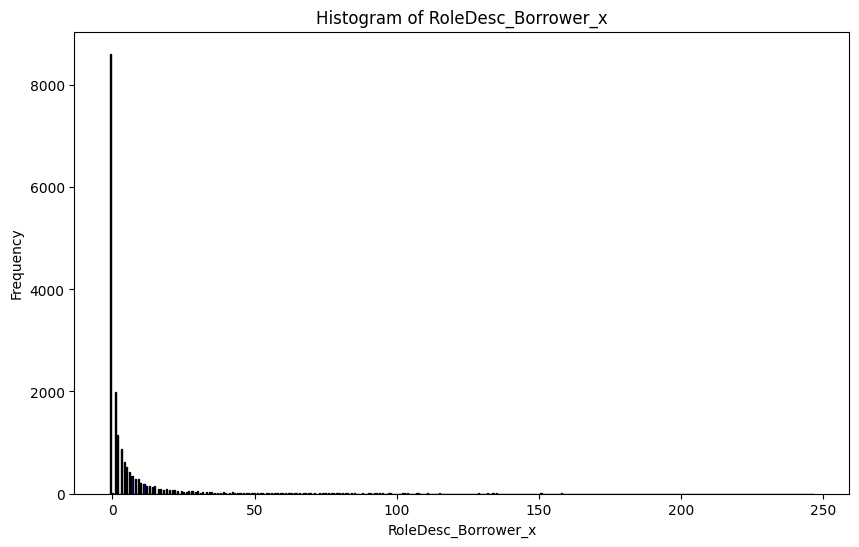

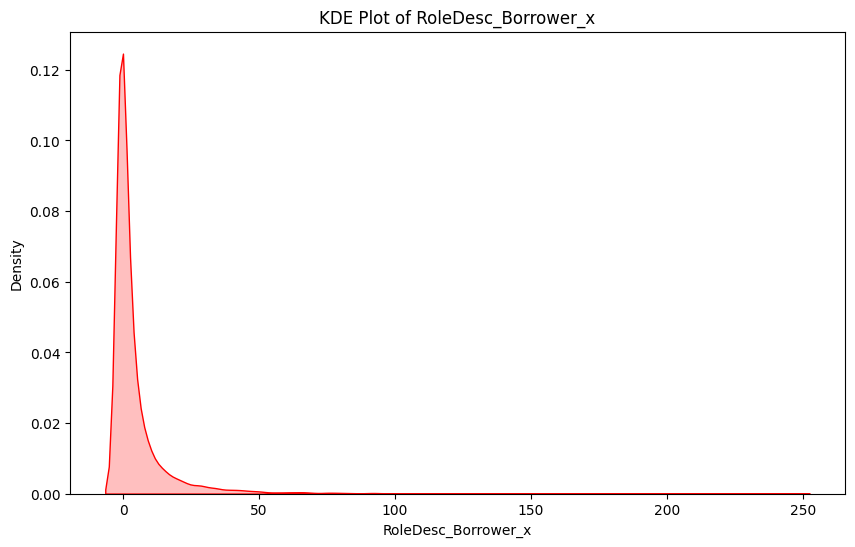

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns  # for KDE plot

# Example data
data = df['RoleDesc_Borrower_x']

# Histogram
plt.figure(figsize=(10, 6))
plt.hist(data, bins='auto', color='blue', edgecolor='black')
plt.title('Histogram of RoleDesc_Borrower_x')
plt.xlabel('RoleDesc_Borrower_x')
plt.ylabel('Frequency')
plt.show()

# KDE Plot (Kernel Density Estimate)
plt.figure(figsize=(10, 6))
sns.kdeplot(data, color='red', fill=True)
plt.title('KDE Plot of RoleDesc_Borrower_x')
plt.xlabel('RoleDesc_Borrower_x')
plt.ylabel('Density')
plt.show()


In [95]:
# from sklearn.preprocessing import KBinsDiscretizer
# import numpy as np

# # Reshape the input to a 2D array
# X = np.array(df['RoleDesc_Borrower_x']).reshape(-1, 1)

# # Create KBinsDiscretizer
# est = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans', subsample=None)

# # Fit and transform
# est.fit(X)
# df['RoleDesc_Borrower_bin'] = est.transform(X)

# # Display the updated DataFrame
# print(df[['RoleDesc_Borrower_x', 'RoleDesc_Borrower_bin']].value_counts())
# # Get bin edges
# bin_edges = est.bin_edges_[0]

# # Display the bin edges
# print("Bin Edges:", bin_edges)

RoleDesc_Borrower_x  RoleDesc_Borrower_bin
-1.0                 0.0                      8618
 1.0                 0.0                      1992
 2.0                 0.0                      1148
 3.0                 0.0                       878
 4.0                 0.0                       618
                                              ... 
 89.0                2.0                         1
 87.0                2.0                         1
 86.0                2.0                         1
 72.0                2.0                         1
 247.0               2.0                         1
Length: 136, dtype: int64
Bin Edges: [ -1.          14.10991137  59.08107444 247.        ]


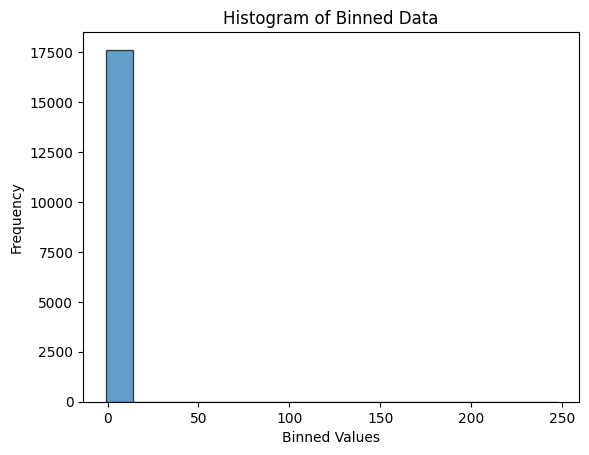

In [96]:
# # Plot the histogram of the binned data
# plt.hist(df['RoleDesc_Borrower_bin'], bins=bin_edges, edgecolor='black', alpha=0.7)
# plt.title('Histogram of Binned Data')
# plt.xlabel('Binned Values')
# plt.ylabel('Frequency')
# plt.show()

In [97]:
# df['RoleDesc_Borrower_bin'].value_counts()

0.0    15936
1.0     1479
2.0      198
Name: RoleDesc_Borrower_bin, dtype: int64

In [98]:
df.drop(columns = ["RoleDesc_Borrower_bin"], inplace = True)

In [99]:
df.columns

Index(['customerId', 'new_loan_type', 'obs', 'fstpd30', 'loanincb_bin',
       'closedcontract_bin', 'closedinadvancecontract_bin',
       'Activecontract_bin', 'cntloans_bin', 'ContractStatus_BC_bin',
       'ContractStatus_BF_bin', 'ContractStatus_BL_bin',
       'ContractStatus_CR_bin', 'ContractStatus_CV_bin',
       'ContractStatus_DA_bin', 'ContractStatus_DI_bin',
       'ContractStatus_DS_bin', 'ContractStatus_FC_bin',
       'ContractStatus_LT_bin', 'ContractStatus_NA_bin',
       'ContractStatus_NP_bin', 'ContractStatus_NS_bin',
       'ContractStatus_PA_bin', 'ContractStatus_PD_bin',
       'ContractStatus_RP_bin', 'ContractStatus_WC_bin',
       'ContractStatus_WF_bin', 'ContractStatus_WO_bin',
       'ContractHistoryType_CreditCards_bin',
       'ContractHistoryType_Installments_bin',
       'ContractHistoryType_NonInstallments_bin',
       'ContractHistoryType_Utilities_bin',
       'ContractTypeDesc_AgriculturalLoan_bin',
       'ContractTypeDesc_BenefitLoan_bin', 'Contra

In [100]:
# 'ContractTypeDesc_Vehicle leasing'

df.rename(columns = {'RoleDesc_Borrower_x':'RoleDesc_Borrower'}, inplace = True)

df = create_bins(df, 'RoleDesc_Borrower', bins_contract_status_cv, labels_contract_status_cv)

# Display the updated DataFrame
print(df[['RoleDesc_Borrower', 'RoleDesc_Borrower_bin']].value_counts())
df.drop(columns = 'RoleDesc_Borrower', inplace = True)


RoleDesc_Borrower  RoleDesc_Borrower_bin
-1.0               -1                       8618
 1.0               1-4                      1992
 2.0               1-4                      1148
 3.0               1-4                       878
 4.0               1-4                       618
                                            ... 
 89.0              >7                          1
 87.0              >7                          1
 86.0              >7                          1
 72.0              >7                          1
 247.0             >7                          1
Length: 136, dtype: int64


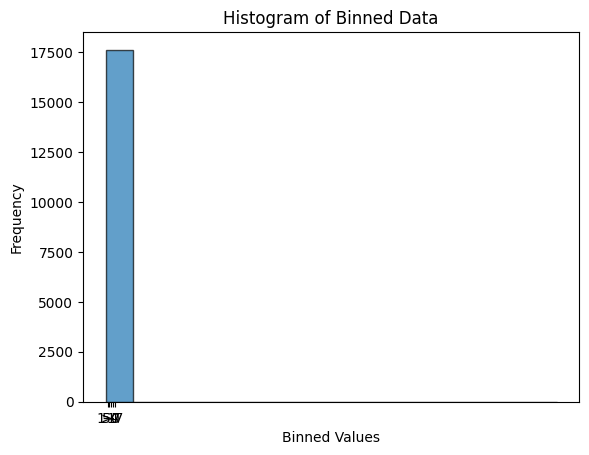

In [101]:
# Plot the histogram of the binned data
plt.hist(df['RoleDesc_Borrower_bin'], bins=bin_edges, edgecolor='black', alpha=0.7)
plt.title('Histogram of Binned Data')
plt.xlabel('Binned Values')
plt.ylabel('Frequency')
plt.show()

In [102]:
df['RoleDesc_Borrower_bin'].value_counts()

-1     8618
1-4    4636
>7     3399
5-7     947
0        13
Name: RoleDesc_Borrower_bin, dtype: int64

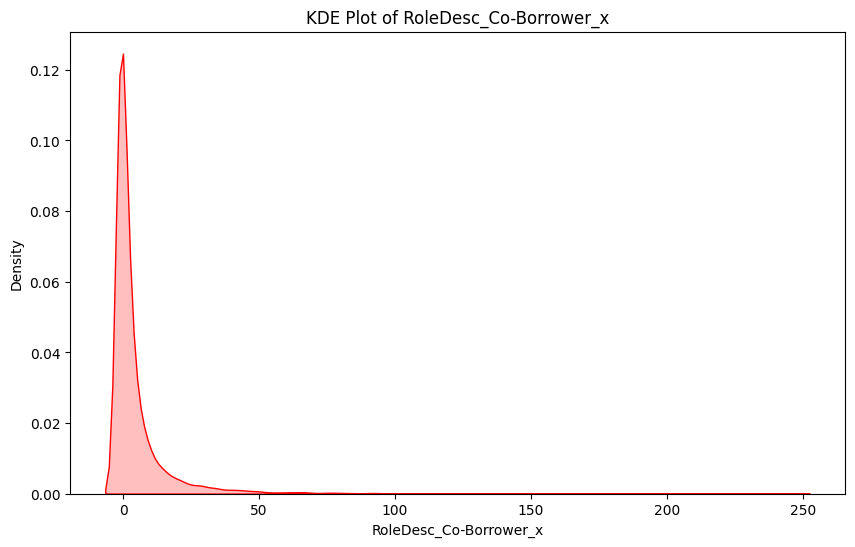

RoleDesc_Co_Borrower  RoleDesc_Co_Borrower_bin
 0.0                  0                           8902
-1.0                  -1                          8618
 1.0                  1-4                           62
 2.0                  1-4                           14
 3.0                  1-4                            6
 4.0                  1-4                            4
 22.0                 >7                             2
 7.0                  >7                             1
 16.0                 >7                             1
 17.0                 >7                             1
 26.0                 >7                             1
 36.0                 >7                             1
dtype: int64


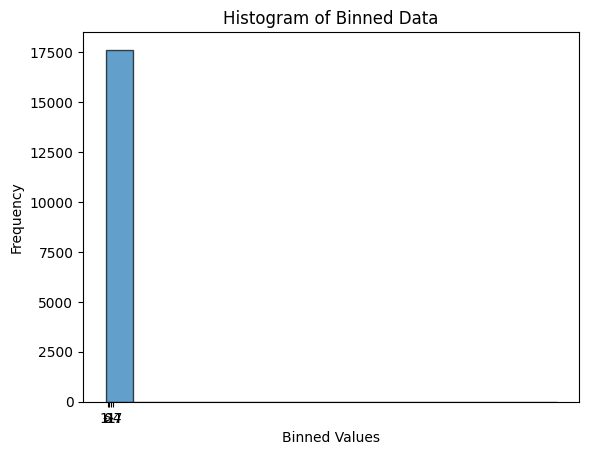

In [104]:
# RoleDesc_Co-Borrower_x

data = df['RoleDesc_Co_Borrower']

# KDE Plot (Kernel Density Estimate)
plt.figure(figsize=(10, 6))
sns.kdeplot(data, color='red', fill=True)
plt.title('KDE Plot of RoleDesc_Co-Borrower_x')
plt.xlabel('RoleDesc_Co-Borrower_x')
plt.ylabel('Density')
plt.show()


df.rename(columns = {'RoleDesc_Co-Borrower_x':'RoleDesc_Co_Borrower'}, inplace = True)

df = create_bins(df, 'RoleDesc_Co_Borrower', bins_contract_status_cv, labels_contract_status_cv)

# Display the updated DataFrame
print(df[['RoleDesc_Co_Borrower', 'RoleDesc_Co_Borrower_bin']].value_counts())
df.drop(columns = 'RoleDesc_Co_Borrower', inplace = True)

# Plot the histogram of the binned data
plt.hist(df['RoleDesc_Co_Borrower_bin'], bins=bin_edges, edgecolor='black', alpha=0.7)
plt.title('Histogram of Binned Data')
plt.xlabel('Binned Values')
plt.ylabel('Frequency')
plt.show()


In [105]:
df['RoleDesc_Co_Borrower_bin'].value_counts()

0      8902
-1     8618
1-4      86
>7        7
5-7       0
Name: RoleDesc_Co_Borrower_bin, dtype: int64

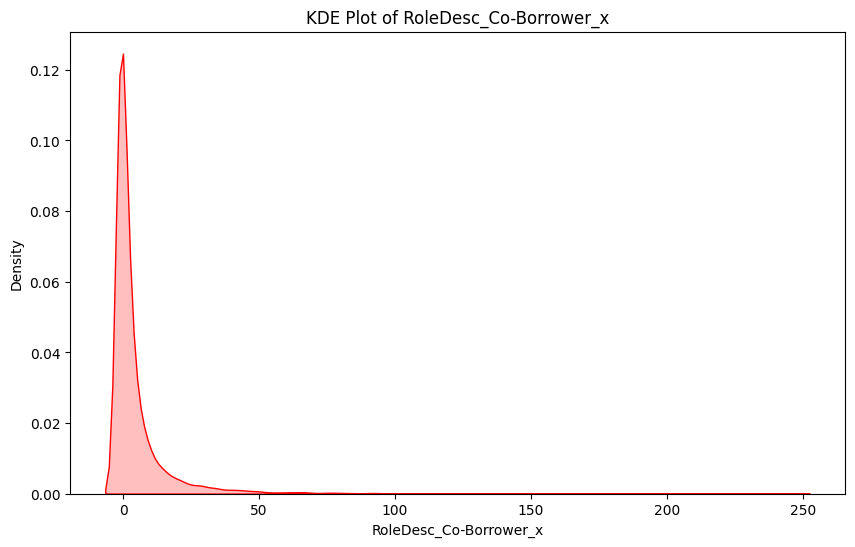

KeyError: 'RoleDesc_Co_Borrower'

In [109]:
# RoleDesc_Co-Borrower_x

data = df['RoleDesc_Co_Borrower']

# KDE Plot (Kernel Density Estimate)
plt.figure(figsize=(10, 6))
sns.kdeplot(data, color='red', fill=True)
plt.title('KDE Plot of RoleDesc_Co-Borrower_x')
plt.xlabel('RoleDesc_Co-Borrower_x')
plt.ylabel('Density')
plt.show()


df.rename(columns = {'RoleDesc_Co-Borrower_x':'RoleDesc_Co_Borrower'}, inplace = True)

df = create_bins(df, 'RoleDesc_Co_Borrower', bins_contract_status_cv, labels_contract_status_cv)

# Display the updated DataFrame
print(df[['RoleDesc_Co_Borrower', 'RoleDesc_Co_Borrower_bin']].value_counts())
df.drop(columns = 'RoleDesc_Co_Borrower', inplace = True)




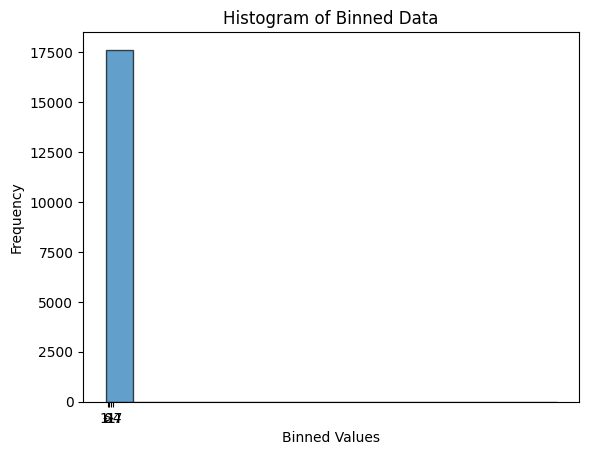

In [110]:
# Plot the histogram of the binned data
plt.hist(df['RoleDesc_Co_Borrower_bin'], bins=bin_edges, edgecolor='black', alpha=0.7)
plt.title('Histogram of Binned Data')
plt.xlabel('Binned Values')
plt.ylabel('Frequency')
plt.show()

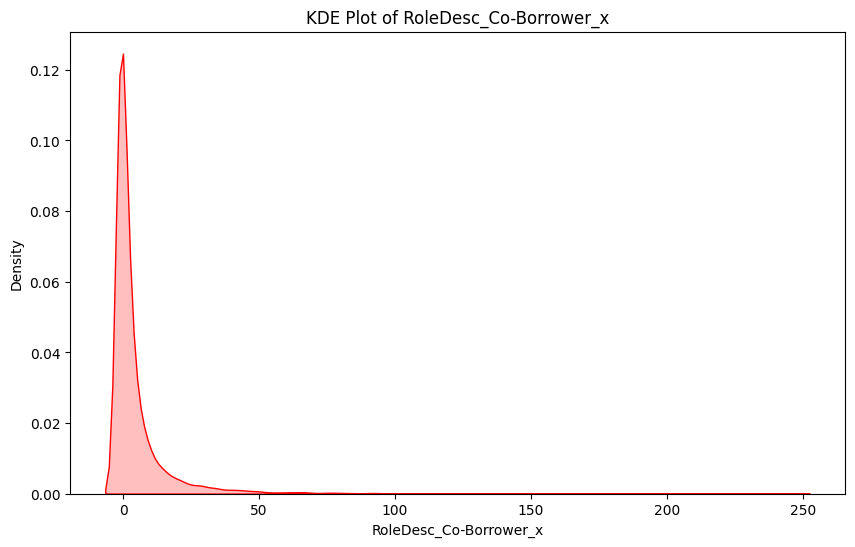

RoleDesc_Guarantor_Surety  RoleDesc_Guarantor_Surety_bin
 0.0                       0                                8991
-1.0                       -1                               8618
 3.0                       1-4                                 2
 5.0                       5-7                                 1
 47.0                      >7                                  1
dtype: int64


In [111]:
# RoleDesc_Guarantor_Surety_x

# KDE Plot (Kernel Density Estimate)
plt.figure(figsize=(10, 6))
sns.kdeplot(data, color='red', fill=True)
plt.title('KDE Plot of RoleDesc_Co-Borrower_x')
plt.xlabel('RoleDesc_Co-Borrower_x')
plt.ylabel('Density')
plt.show()


df.rename(columns = {'RoleDesc_Guarantor_Surety_x':'RoleDesc_Guarantor_Surety'}, inplace = True)

df = create_bins(df, 'RoleDesc_Guarantor_Surety', bins_contract_status_cv, labels_contract_status_cv)

# Display the updated DataFrame
print(df[['RoleDesc_Guarantor_Surety', 'RoleDesc_Guarantor_Surety_bin']].value_counts())
df.drop(columns = 'RoleDesc_Guarantor_Surety', inplace = True)




In [113]:
sq = """select customerId, min(coalesce(cast(CreditLimit as int64), 0)) mincreditlimit, max(coalesce(cast(CreditLimit as int64), 0)) maxcreditlimit 
from prj-prod-dataplatform.risk_credit_cic_data.granted_contracts
group by 1;"""

dfd = client.query(sq).to_dataframe(progress_bar_type='tqdm')
dfd['customerId'] = dfd["customerId"].astype(np.int64)
df = df.merge(dfd, left_on='customerId', right_on='customerId', how = 'left')
dfd.to_csv("creditlimit.csv")
df.to_csv("df.csv", index = False)
del(dfd)
df.head()


Job ID d8a30bcf-8d83-4b0c-849e-fa70d524d832 successfully executed: 100%|██████████|
Downloading: 100%|██████████|


,customerId,new_loan_type,obs,fstpd30,loanincb_bin,closedcontract_bin,closedinadvancecontract_bin,Activecontract_bin,cntloans_bin,ContractStatus_BC_bin,ContractStatus_BF_bin,ContractStatus_BL_bin,ContractStatus_CR_bin,ContractStatus_CV_bin,ContractStatus_DA_bin,ContractStatus_DI_bin,ContractStatus_DS_bin,ContractStatus_FC_bin,ContractStatus_LT_bin,ContractStatus_NA_bin,ContractStatus_NP_bin,ContractStatus_NS_bin,ContractStatus_PA_bin,ContractStatus_PD_bin,ContractStatus_RP_bin,ContractStatus_WC_bin,ContractStatus_WF_bin,ContractStatus_WO_bin,ContractHistoryType_CreditCards_bin,ContractHistoryType_Installments_bin,ContractHistoryType_NonInstallments_bin,ContractHistoryType_Utilities_bin,ContractTypeDesc_AgriculturalLoan_bin,ContractTypeDesc_BenefitLoan_bin,ContractTypeDesc_BusinessLoan_bin,ContractTypeDesc_CreditCard_bin,ContractTypeDesc_CreditCard_MultiCurrency_bin,ContractTypeDesc_CreditCard_SharedLimit_bin,ContractTypeDesc_CreditLine_bin,ContractTypeDesc_Homeequityloan_bin,ContractTypeDesc_Insurance_LifeInsurance_bin,ContractTypeDesc_L_C_bin,ContractTypeDesc_LoanLine_bin,ContractTypeDesc_Mortgage_RealEstate_bin,ContractTypeDesc_OmnibusLine_bin,ContractTypeDesc_PersonalLoan_bin,ContractTypeDesc_ProvidentLoan_bin,ContractTypeDesc_Realestateleasing_bin,ContractTypeDesc_RevolvingCredit_bin,ContractTypeDesc_SWAPLoan_bin,ContractTypeDesc_Salaryloan_bin,ContractTypeDesc_ShortTermLoan_bin,ContractTypeDesc_StudentLoan_bin,ContractTypeDesc_TermLoan_bin,ContractTypeDesc_TimeLoan_bin,ContractTypeDesc_TrustLoan_bin,ContractTypeDesc_Unsecuredloan_bin,ContractTypeDesc_VehicleLoan_bin,ContractTypeDesc_Vehicleleasing_bin,RoleDesc_Borrower_bin,RoleDesc_Co_Borrower_bin,RoleDesc_Guarantor_Surety_bin,mincreditlimit,maxcreditlimit
0,2169925,Quick,1,0,"(-0.09, 18.0]","(-0.2, 40.0]","(-0.167, 33.4]","(-0.146, 29.2]","(-0.007, 1.4]",0,0,0,0,1-4,0,0,0,0,0,1-4,0,0,0,0,0,0,0,0,1-4,0,1-4,0,0,0,0,0,0,1-4,1-4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1-4,0,0,0,9000
1,2025886,Quick,1,0,"(-0.09, 18.0]","(-0.2, 40.0]","(-0.167, 33.4]","(-0.146, 29.2]","(-0.007, 1.4]",-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,<NA>,<NA>
2,2224518,Quick,1,0,"(-0.09, 18.0]","(-0.2, 40.0]","(-0.167, 33.4]","(-0.146, 29.2]","(-0.007, 1.4]",-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,<NA>,<NA>
3,2029675,Quick,1,0,"(-0.09, 18.0]","(-0.2, 40.0]","(-0.167, 33.4]","(-0.146, 29.2]","(-0.007, 1.4]",-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,<NA>,<NA>
4,2041621,Quick,1,0,"(-0.09, 18.0]","(-0.2, 40.0]","(-0.167, 33.4]","(-0.146, 29.2]","(-0.007, 1.4]",0,0,0,0,1-4,0,0,0,0,0,>7,0,0,0,0,0,0,0,1-4,1-4,5-7,1-4,0,0,0,0,1-4,0,1-4,0,0,0,0,0,0,1-4,5-7,0,0,0,0,0,0,0,0,0,0,0,1-4,0,>7,0,0,0,180000


In [114]:
# select only numerical columns
num_cols = df.select_dtypes(include=['int', 'float']).columns

# fill NaN values with 0 in numerical columns
df[num_cols] = df[num_cols].fillna(0)
df.head()

,customerId,new_loan_type,obs,fstpd30,loanincb_bin,closedcontract_bin,closedinadvancecontract_bin,Activecontract_bin,cntloans_bin,ContractStatus_BC_bin,ContractStatus_BF_bin,ContractStatus_BL_bin,ContractStatus_CR_bin,ContractStatus_CV_bin,ContractStatus_DA_bin,ContractStatus_DI_bin,ContractStatus_DS_bin,ContractStatus_FC_bin,ContractStatus_LT_bin,ContractStatus_NA_bin,ContractStatus_NP_bin,ContractStatus_NS_bin,ContractStatus_PA_bin,ContractStatus_PD_bin,ContractStatus_RP_bin,ContractStatus_WC_bin,ContractStatus_WF_bin,ContractStatus_WO_bin,ContractHistoryType_CreditCards_bin,ContractHistoryType_Installments_bin,ContractHistoryType_NonInstallments_bin,ContractHistoryType_Utilities_bin,ContractTypeDesc_AgriculturalLoan_bin,ContractTypeDesc_BenefitLoan_bin,ContractTypeDesc_BusinessLoan_bin,ContractTypeDesc_CreditCard_bin,ContractTypeDesc_CreditCard_MultiCurrency_bin,ContractTypeDesc_CreditCard_SharedLimit_bin,ContractTypeDesc_CreditLine_bin,ContractTypeDesc_Homeequityloan_bin,ContractTypeDesc_Insurance_LifeInsurance_bin,ContractTypeDesc_L_C_bin,ContractTypeDesc_LoanLine_bin,ContractTypeDesc_Mortgage_RealEstate_bin,ContractTypeDesc_OmnibusLine_bin,ContractTypeDesc_PersonalLoan_bin,ContractTypeDesc_ProvidentLoan_bin,ContractTypeDesc_Realestateleasing_bin,ContractTypeDesc_RevolvingCredit_bin,ContractTypeDesc_SWAPLoan_bin,ContractTypeDesc_Salaryloan_bin,ContractTypeDesc_ShortTermLoan_bin,ContractTypeDesc_StudentLoan_bin,ContractTypeDesc_TermLoan_bin,ContractTypeDesc_TimeLoan_bin,ContractTypeDesc_TrustLoan_bin,ContractTypeDesc_Unsecuredloan_bin,ContractTypeDesc_VehicleLoan_bin,ContractTypeDesc_Vehicleleasing_bin,RoleDesc_Borrower_bin,RoleDesc_Co_Borrower_bin,RoleDesc_Guarantor_Surety_bin,mincreditlimit,maxcreditlimit
0,2169925,Quick,1,0,"(-0.09, 18.0]","(-0.2, 40.0]","(-0.167, 33.4]","(-0.146, 29.2]","(-0.007, 1.4]",0,0,0,0,1-4,0,0,0,0,0,1-4,0,0,0,0,0,0,0,0,1-4,0,1-4,0,0,0,0,0,0,1-4,1-4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1-4,0,0,0,9000
1,2025886,Quick,1,0,"(-0.09, 18.0]","(-0.2, 40.0]","(-0.167, 33.4]","(-0.146, 29.2]","(-0.007, 1.4]",-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0
2,2224518,Quick,1,0,"(-0.09, 18.0]","(-0.2, 40.0]","(-0.167, 33.4]","(-0.146, 29.2]","(-0.007, 1.4]",-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0
3,2029675,Quick,1,0,"(-0.09, 18.0]","(-0.2, 40.0]","(-0.167, 33.4]","(-0.146, 29.2]","(-0.007, 1.4]",-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0
4,2041621,Quick,1,0,"(-0.09, 18.0]","(-0.2, 40.0]","(-0.167, 33.4]","(-0.146, 29.2]","(-0.007, 1.4]",0,0,0,0,1-4,0,0,0,0,0,>7,0,0,0,0,0,0,0,1-4,1-4,5-7,1-4,0,0,0,0,1-4,0,1-4,0,0,0,0,0,0,1-4,5-7,0,0,0,0,0,0,0,0,0,0,0,1-4,0,>7,0,0,0,180000


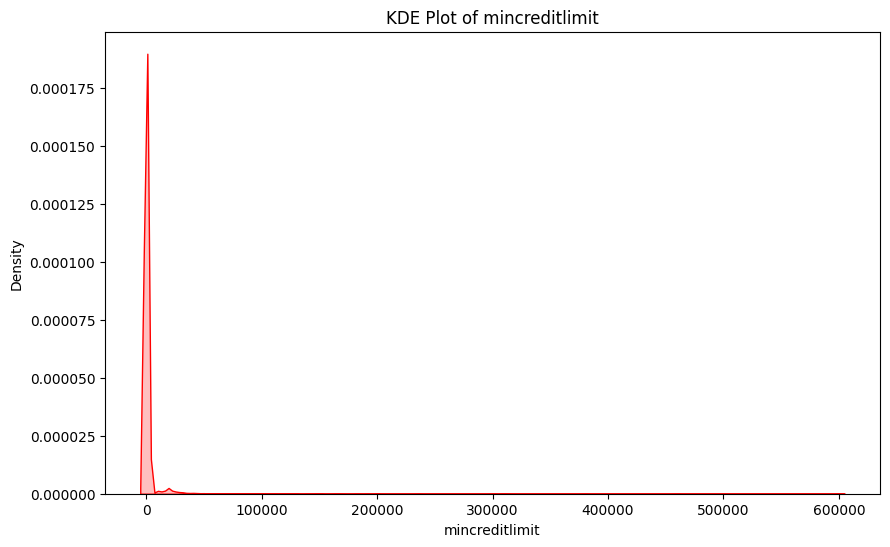

In [117]:
# mincreditlimit
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df['mincreditlimit'] is a Pandas Series
data = df['mincreditlimit']

# Convert to numeric (ignoring errors, non-numeric values will become NaN)
data_numeric = pd.to_numeric(data, errors='coerce')

# Drop NaN values
data_numeric = data_numeric.dropna()

# Convert data to NumPy array
data_array = np.array(data_numeric)

# KDE Plot (Kernel Density Estimate)
plt.figure(figsize=(10, 6))
sns.kdeplot(data_array, color='red', fill=True)
plt.title('KDE Plot of mincreditlimit')
plt.xlabel('mincreditlimit')
plt.ylabel('Density')
plt.show()


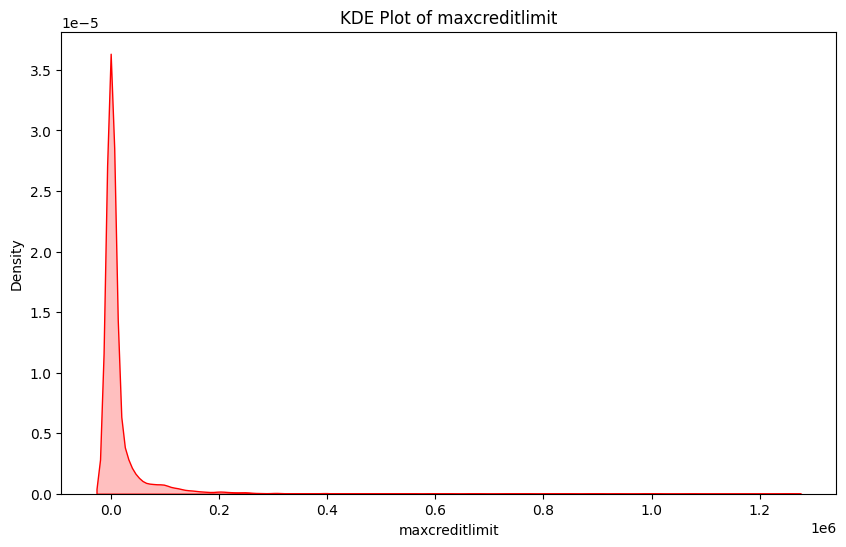

In [118]:
# maxcreditlimit
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df['maxcreditlimit'] is a Pandas Series
data = df['maxcreditlimit']

# Convert to numeric (ignoring errors, non-numeric values will become NaN)
data_numeric = pd.to_numeric(data, errors='coerce')

# Drop NaN values
data_numeric = data_numeric.dropna()

# Convert data to NumPy array
data_array = np.array(data_numeric)

# KDE Plot (Kernel Density Estimate)
plt.figure(figsize=(10, 6))
sns.kdeplot(data_array, color='red', fill=True)
plt.title('KDE Plot of maxcreditlimit')
plt.xlabel('maxcreditlimit')
plt.ylabel('Density')
plt.show()


In [120]:
df['mincreditlimit'].describe()

count         17613.0
mean      1615.596264
std      12209.816915
min               0.0
25%               0.0
50%               0.0
75%               0.0
max          600000.0
Name: mincreditlimit, dtype: Float64

# Weight of Evidence and Information value for all variables

In [ ]:
import pandas as pd
import numpy as np

def calculate_woe_iv(data, target, column):
    """
    Calculate Weight of Evidence (WoE) and Information Value (IV) for a given column.
    
    Parameters:
    - data: DataFrame containing the data
    - target: Target variable column name
    - column: Column for which WoE and IV are calculated
    
    Returns:
    - woe_iv_df: DataFrame containing WoE and IV for the given column
    """
    # Create a dataframe to store the results
    woe_iv_df = pd.DataFrame(columns=['Column', 'Value', 'Event', 'Non-Event', 'WoE', 'IV'])
    
    # Extract unique values from the column
    values = data[column].unique()
    
    for value in values:
        # Calculate the count of events and non-events
        event_count = data[(data[target] == 1) & (data[column] == value)].shape[0]
        non_event_count = data[(data[target] == 0) & (data[column] == value)].shape[0]
        
        # Avoid division by zero by adding a small constant
        if event_count == 0:
            event_count += 0.5
        if non_event_count == 0:
            non_event_count += 0.5
        
        # Calculate WoE and IV
        woe = np.log((event_count / data[data[target] == 1].shape[0]) / (non_event_count / data[data[target] == 0].shape[0]))
        iv = (event_count / data[data[target] == 1].shape[0] - non_event_count / data[data[target] == 0].shape[0]) * woe
        
        # Append results to the DataFrame
        woe_iv_df = woe_iv_df.append({'Column': column, 'Value': value, 'Event': event_count, 'Non-Event': non_event_count, 'WoE': woe, 'IV': iv}, ignore_index=True)
    
    return woe_iv_df

# Assuming your dataframe is named 'df'
# Assuming the target variable column is 'fstpd30'

result_df = pd.DataFrame()

# Iterate through each column for WoE and IV calculation
for column in ['loanincb_bin', 'closedcontract_bin', 'closedinadvancecontract_bin',
               'Activecontract_bin', 'cntloans_bin', 'ContractStatus_BC',
               'ContractStatus_BF', 'ContractStatus_BL', 'ContractStatus_CR',
               'ContractStatus_CV', 'ContractStatus_DA', 'ContractStatus_DI',
               'ContractStatus_DS', 'ContractStatus_FC', 'ContractStatus_LT',
               'ContractStatus_NA', 'ContractStatus_NP', 'ContractStatus_NS',
               'ContractStatus_PA', 'ContractStatus_PD', 'ContractStatus_RP',
               'ContractStatus_WC', 'ContractStatus_WF', 'ContractStatus_WO']:
    
    # Calculate WoE and IV for each column
    woe_iv_result = calculate_woe_iv(df, 'fstpd30', column)
    
    # Add the results to the main DataFrame
    result_df = pd.concat([result_df, woe_iv_result], ignore_index=True)

# Display the resulting DataFrame
print(result_df)


In [ ]:
result_df.to_csv("result_df.csv")